<a href="https://colab.research.google.com/github/vsadykov/kineticsim_reader/blob/main/ML_VDFs_modeltesting_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules and dependences

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

# Loading VDFs and augmenting them with the particle abundances

In [2]:
featurevector_allvdfs_all_4040 = np.load('allsimulations.mldata_vdfs_4040.npy')
featurevector_allvdfs_all_6060 = np.load('allsimulations.mldata_vdfs_6060.npy')
print(featurevector_allvdfs_all_4040.shape)
print(featurevector_allvdfs_all_6060.shape)

(1253, 2, 40, 40)
(1253, 2, 60, 60)


In [3]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
print(featurevector_allmoments.shape)
pops_h = featurevector_allmoments[:,18]
pops_he = featurevector_allmoments[:,19]

(1253, 20)


In [4]:
ncases = featurevector_allvdfs_all_4040.shape[0]

featurevector_allvdfs_all_4040_aug = np.zeros([ncases,4,40,40], dtype=float)
featurevector_allvdfs_all_4040_aug[:,0:2,:,:] = np.log10(featurevector_allvdfs_all_4040 + 1)
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_4040_aug[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_4040_aug[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_4040_aug[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_4040_aug[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_4040_aug[ncase,1,:,:])
  featurevector_allvdfs_all_4040_aug[ncase,2,:,:] += pops_h[ncase]
  featurevector_allvdfs_all_4040_aug[ncase,3,:,:] += pops_he[ncase]

featurevector_allvdfs_all_6060_aug = np.zeros([ncases,4,60,60], dtype=float)
featurevector_allvdfs_all_6060_aug[:,0:2,:,:] = np.log10(featurevector_allvdfs_all_6060 + 1)
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_6060_aug[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_6060_aug[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_6060_aug[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_6060_aug[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_6060_aug[ncase,1,:,:])
  featurevector_allvdfs_all_6060_aug[ncase,2,:,:] += pops_h[ncase]
  featurevector_allvdfs_all_6060_aug[ncase,3,:,:] += pops_he[ncase]

print(featurevector_allvdfs_all_4040_aug.shape)
print(featurevector_allvdfs_all_6060_aug.shape)

(1253, 4, 40, 40)
(1253, 4, 60, 60)


0.9 0.9
0.05 0.05


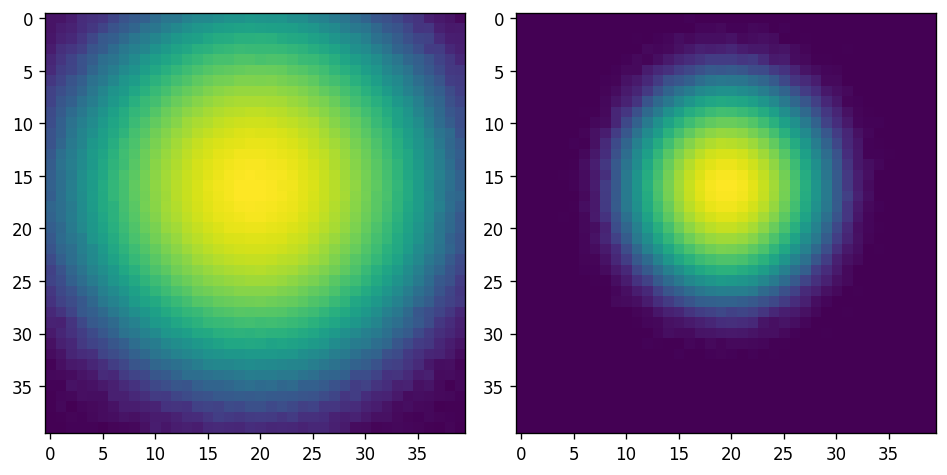

In [5]:
im, ax = plt.subplots(1, 2, figsize=(8,8), dpi=120)

ax[0].imshow(featurevector_allvdfs_all_4040_aug[100,0,:,:])
ax[1].imshow(featurevector_allvdfs_all_4040_aug[100,1,:,:])

print(np.amin(featurevector_allvdfs_all_4040_aug[100,2,:,:]), np.amax(featurevector_allvdfs_all_4040_aug[100,2,:,:]))
print(np.amin(featurevector_allvdfs_all_4040_aug[100,3,:,:]), np.amax(featurevector_allvdfs_all_4040_aug[100,3,:,:]))

plt.tight_layout()
plt.show()

Loading labels for 0.001 anisotropy or magnetic energy change

In [6]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('allsimulations.timep_array_all.npy')
labels_an = np.load('allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

print(labels_allmoments.shape)

The total number of data points is: 1253
Among them unstable (positive) samples: 398
(1253,)


In [7]:
simnames = np.load('allsimulations.simnames_all.npy')

Producing 10-CV data set separations

In [8]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x7a9dca22f300>

# Best architecture for 40x40 VDFs (5-fold CV for faster assessment)

In [9]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*5*5, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 5 * 5)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 5 * 5)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*10*10, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 10 * 10)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*10*10, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 10 * 10)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*20*20, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 20 * 20)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*20*20, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 20 * 20)
    x = self.linearcell(x)
    return x

In [10]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 2000/2000 [02:44<00:00, 12.17it/s]


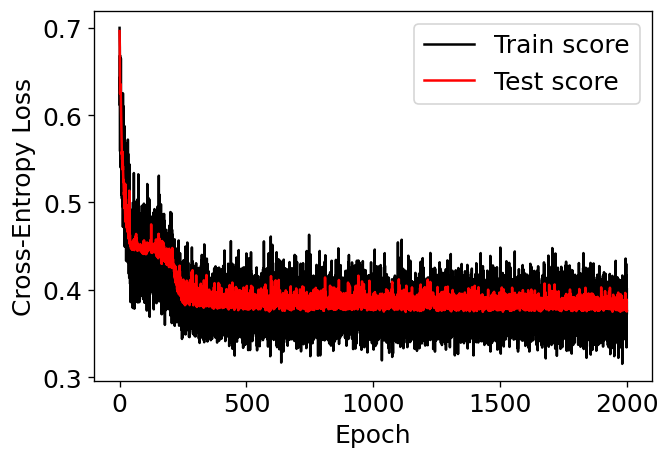

Optimal epoch count for the current training: 1128
0.9396135265700483 7896
0.9396135265700483 0.8333333333333334
---------------------------------------------


100%|██████████| 2000/2000 [02:40<00:00, 12.48it/s]


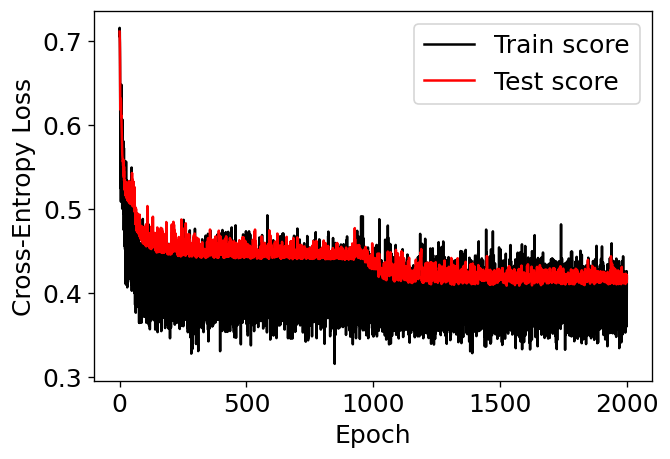

Optimal epoch count for the current training: 1525
0.9130434782608695 10681
0.9130434782608695 0.7966446365022877
---------------------------------------------


100%|██████████| 2000/2000 [01:49<00:00, 18.29it/s]


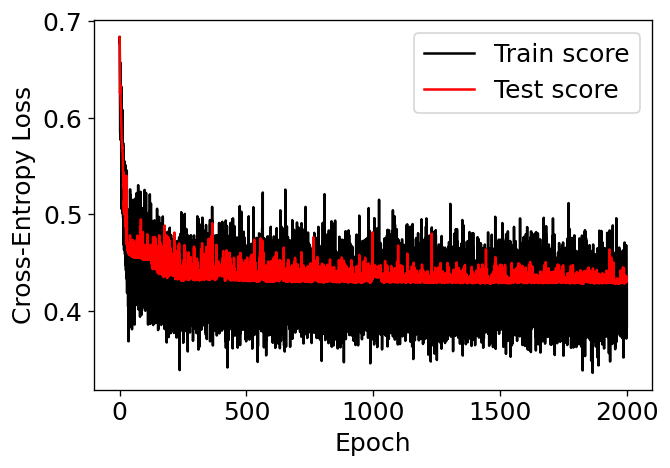

Optimal epoch count for the current training: 1821
0.8888888888888888 12750
0.8888888888888888 0.6775362318840579
---------------------------------------------


100%|██████████| 2000/2000 [01:50<00:00, 18.17it/s]


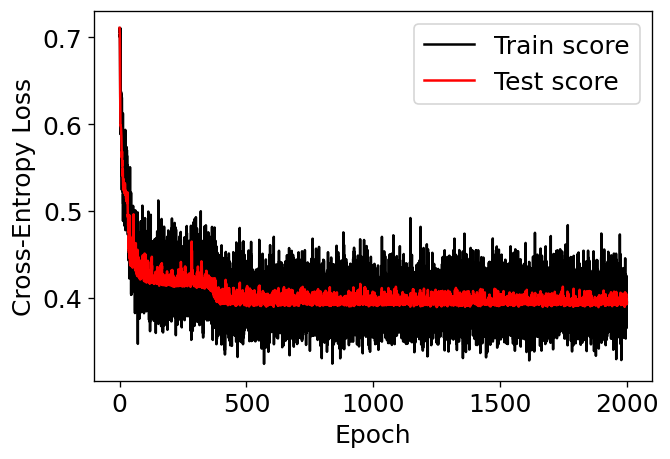

Optimal epoch count for the current training: 1888
0.927536231884058 13216
0.927536231884058 0.8248385186020929
---------------------------------------------


100%|██████████| 2000/2000 [01:54<00:00, 17.42it/s]


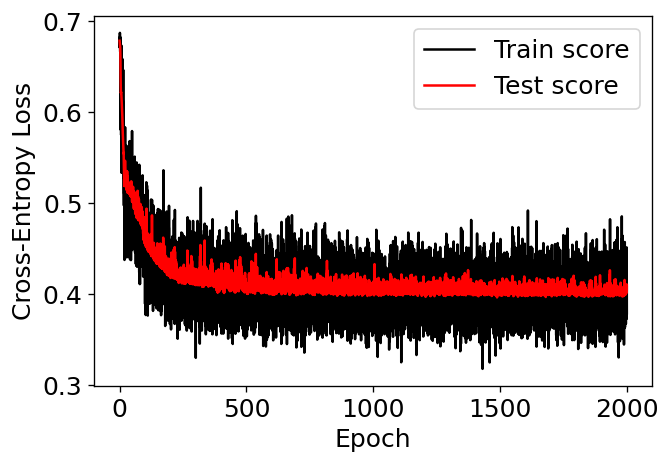

Optimal epoch count for the current training: 1488
0.9202898550724637 10417
0.9202898550724637 0.7914804805608326
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN2
TP = 108.4+/-7.657675887630659
TN = 271.6+/-4.498888751680798
FP = 9.8+/-5.635601121442148
FN = 24.2+/-9.765244492586962
Acc = 0.9178743961352657+/-0.016942683977536416
TSS = 0.7847666401765208+/-0.05594461910985017


In [11]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

100%|██████████| 2000/2000 [01:51<00:00, 17.96it/s]


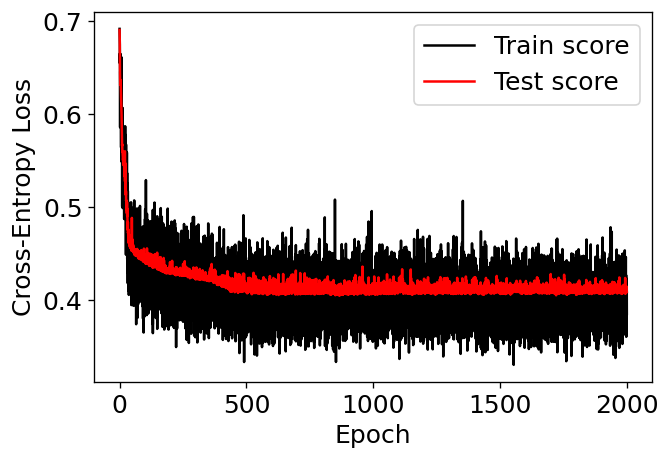

Optimal epoch count for the current training: 866
0.9130434782608695 6067
0.9130434782608695 0.7934782608695652
---------------------------------------------


100%|██████████| 2000/2000 [01:47<00:00, 18.63it/s]


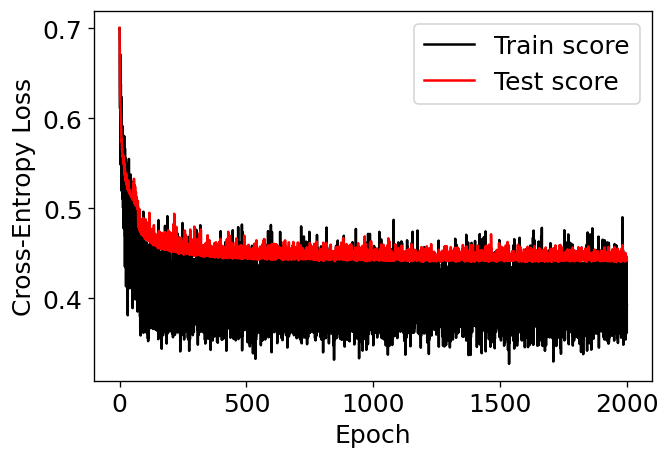

Optimal epoch count for the current training: 1958
0.8792270531400966 13707
0.8792270531400966 0.7507826505766195
---------------------------------------------


100%|██████████| 2000/2000 [01:47<00:00, 18.59it/s]


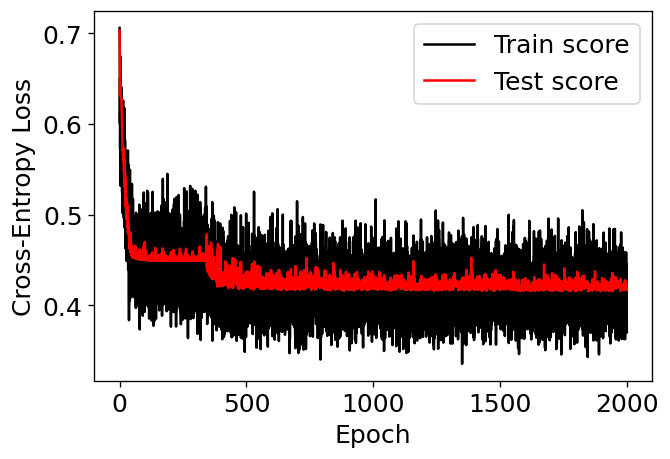

Optimal epoch count for the current training: 1849
0.9009661835748792 12943
0.9009661835748792 0.7173913043478262
---------------------------------------------


100%|██████████| 2000/2000 [01:45<00:00, 18.95it/s]


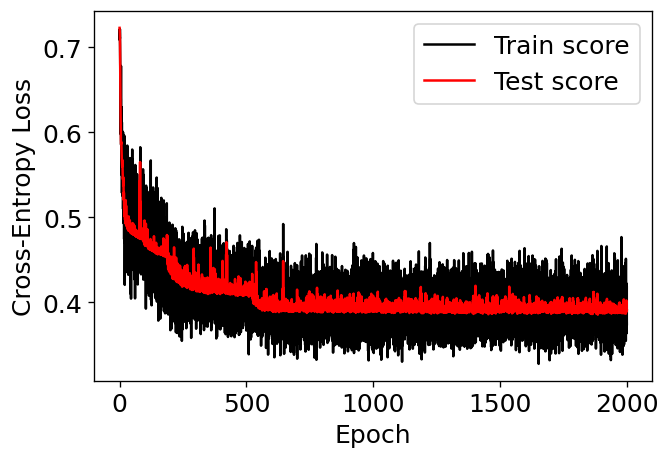

Optimal epoch count for the current training: 1885
0.9347826086956522 13197
0.9347826086956522 0.8302259329252814
---------------------------------------------


100%|██████████| 2000/2000 [01:45<00:00, 19.05it/s]


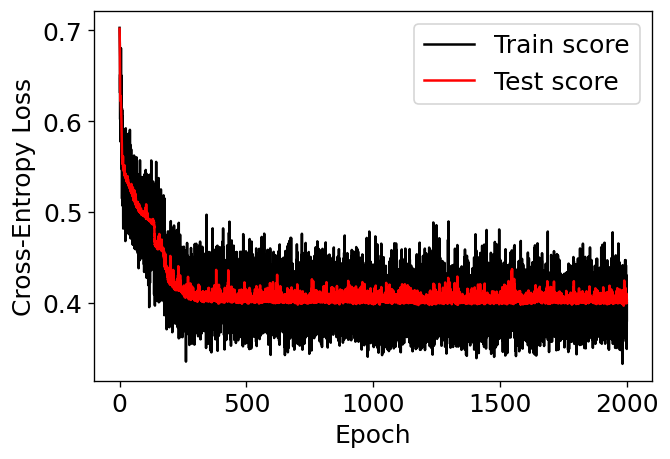

Optimal epoch count for the current training: 1987
0.9154589371980676 13912
0.9154589371980676 0.8002033553634976
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN1
TP = 110.4+/-6.248199740725323
TN = 265.8+/-11.01635148313633
FP = 15.6+/-9.221713506718803
FN = 22.2+/-7.573638491504595
Acc = 0.9086956521739131+/-0.018293812781412067
TSS = 0.778416300816558+/-0.03968235170778806


In [12]:
# NETWORK: VDFCNN_4040_CNN3_CONN1
ARCH = 'VDFCNN_4040_CNN3_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

100%|██████████| 2000/2000 [01:47<00:00, 18.62it/s]


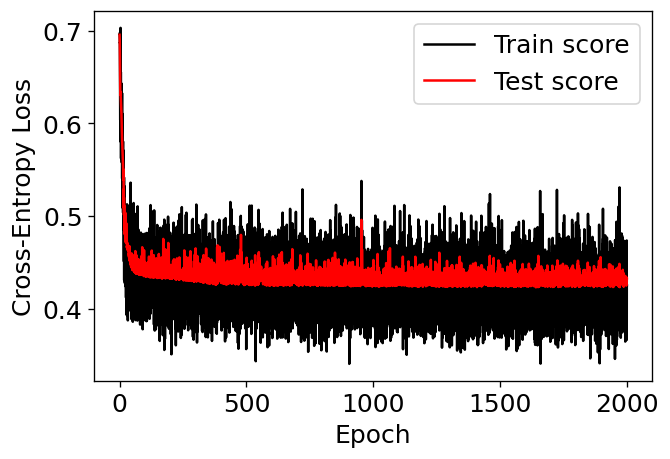

Optimal epoch count for the current training: 1641
0.893719806763285 11489
0.893719806763285 0.6884057971014492
---------------------------------------------


100%|██████████| 2000/2000 [01:41<00:00, 19.61it/s]


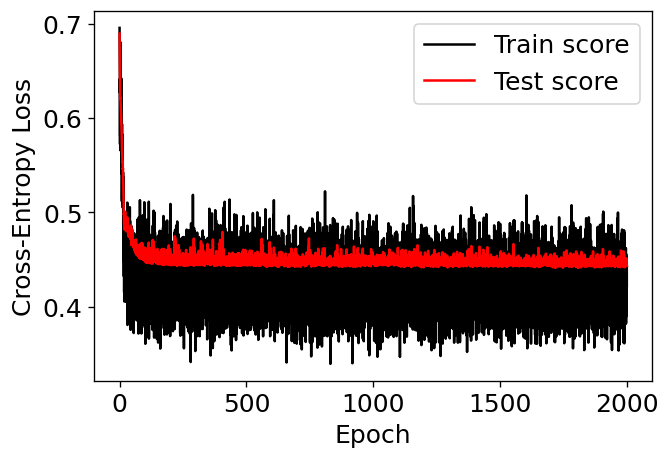

Optimal epoch count for the current training: 1807
0.8768115942028986 12652
0.8768115942028986 0.6521820565648998
---------------------------------------------


100%|██████████| 2000/2000 [01:50<00:00, 18.17it/s]


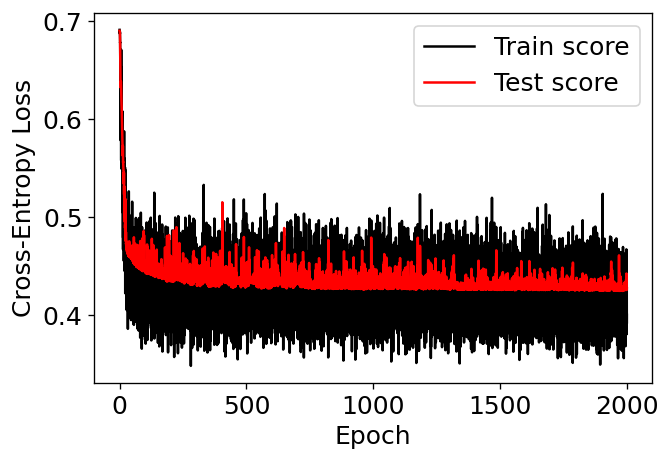

Optimal epoch count for the current training: 1972
0.8913043478260869 13808
0.8913043478260869 0.6884057971014493
---------------------------------------------


100%|██████████| 2000/2000 [01:40<00:00, 19.85it/s]


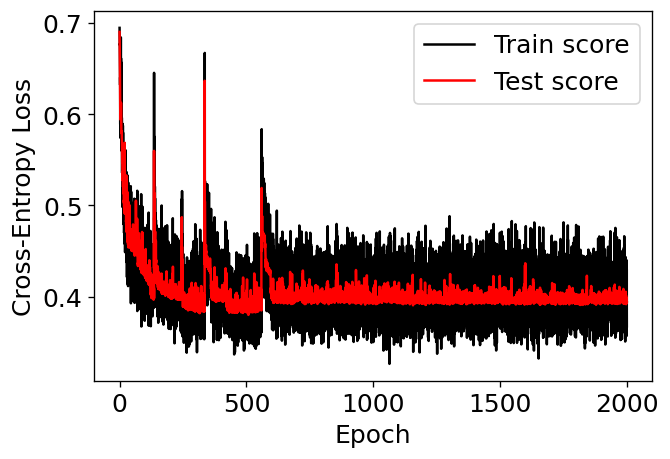

Optimal epoch count for the current training: 507
0.9396135265700483 3555
0.9396135265700483 0.8613093391250387
---------------------------------------------


100%|██████████| 2000/2000 [01:43<00:00, 19.33it/s]


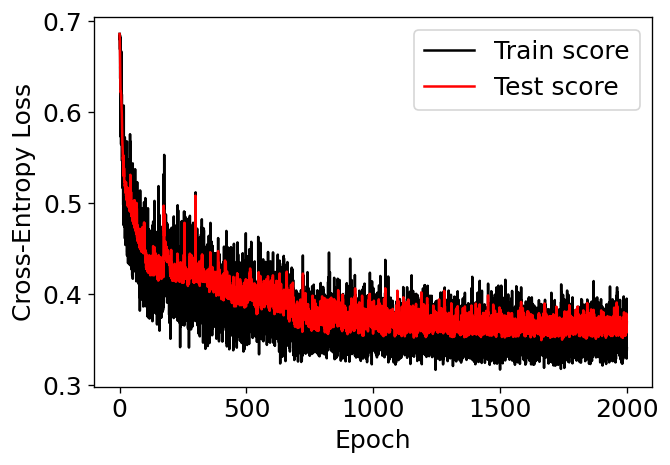

Optimal epoch count for the current training: 1662
0.9685990338164251 11640
0.9685990338164251 0.9141358734915581
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN2
TP = 103.4+/-11.637869220780924
TN = 275.0+/-2.9664793948382653
FP = 6.4+/-4.498888751680798
FN = 29.2+/-15.27612516314265
Acc = 0.9140096618357487+/-0.03448612231415409
TSS = 0.760887772676879+/-0.10572953957457755


In [13]:
# NETWORK: VDFCNN_4040_CNN2_CONN2
ARCH = 'VDFCNN_4040_CNN2_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

100%|██████████| 2000/2000 [01:38<00:00, 20.27it/s]


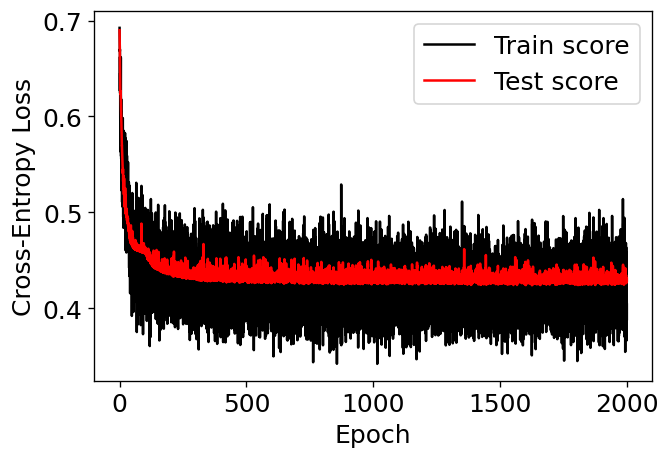

Optimal epoch count for the current training: 1626
0.8888888888888888 11384
0.8888888888888888 0.6775362318840579
---------------------------------------------


100%|██████████| 2000/2000 [01:40<00:00, 19.87it/s]


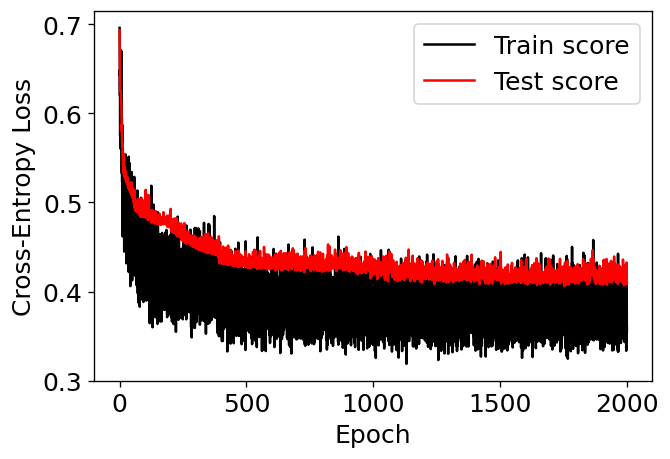

Optimal epoch count for the current training: 1753
0.9082125603864735 12271
0.9082125603864735 0.7895271987798678
---------------------------------------------


100%|██████████| 2000/2000 [01:37<00:00, 20.42it/s]


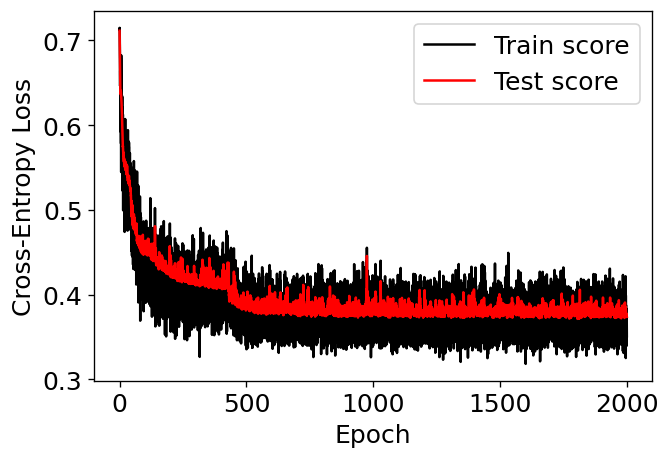

Optimal epoch count for the current training: 1805
0.9444444444444444 12636
0.9444444444444444 0.855072463768116
---------------------------------------------


100%|██████████| 2000/2000 [01:34<00:00, 21.25it/s]


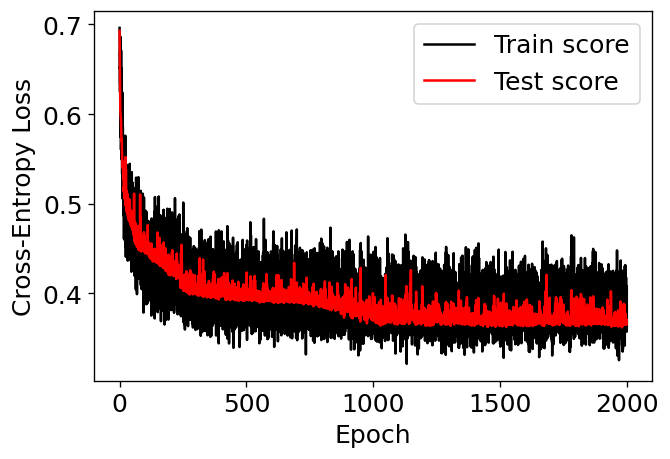

Optimal epoch count for the current training: 1979
0.9565217391304348 13859
0.9565217391304348 0.9143090852678194
---------------------------------------------


100%|██████████| 2000/2000 [01:35<00:00, 20.85it/s]


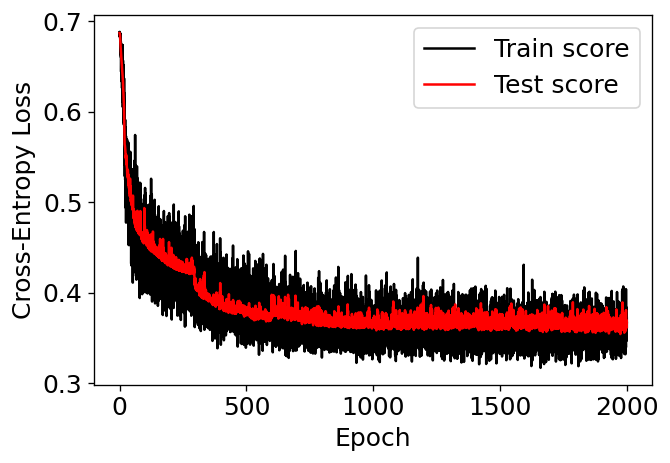

Optimal epoch count for the current training: 1974
0.966183574879227 13819
0.966183574879227 0.9145372327616192
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN1
TP = 114.0+/-10.13903348450926
TN = 272.2+/-6.079473661428265
FP = 9.2+/-5.946427498927402
FN = 18.6+/-13.230268326832983
Acc = 0.9328502415458937+/-0.029480475946651902
TSS = 0.8301964424922961+/-0.08918099494796447


In [14]:
# NETWORK: VDFCNN_4040_CNN2_CONN1
ARCH = 'VDFCNN_4040_CNN2_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

100%|██████████| 2000/2000 [01:27<00:00, 22.86it/s]


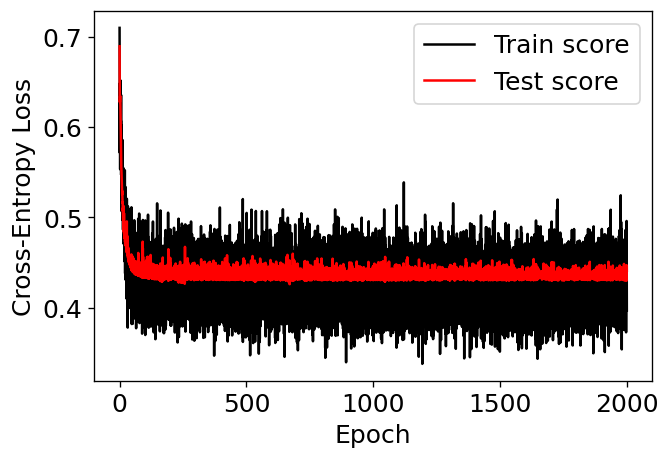

Optimal epoch count for the current training: 670
0.8888888888888888 4693
0.8888888888888888 0.6811594202898551
---------------------------------------------


 33%|███▎      | 654/2000 [04:13<08:41,  2.58it/s]  


KeyboardInterrupt: 

In [15]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_4040_CNN3_CONN2

Running for the best configuration now...

100%|██████████| 3000/3000 [02:10<00:00, 22.90it/s]


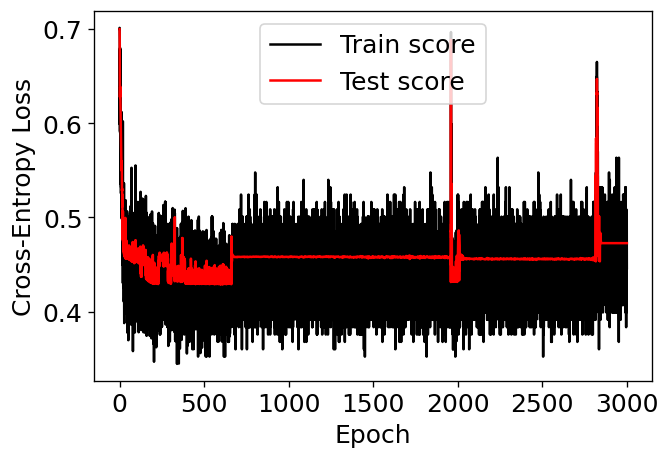

Optimal epoch count for the current training: 597
0.8840579710144928 4180
0.8840579710144928 0.6702898550724637
---------------------------------------------


100%|██████████| 3000/3000 [02:06<00:00, 23.65it/s]


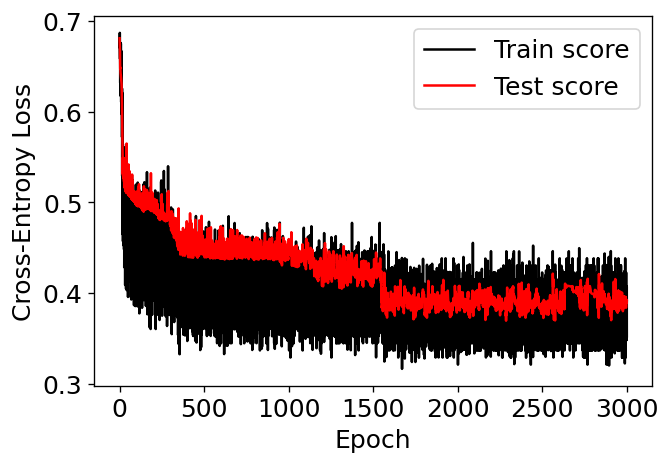

Optimal epoch count for the current training: 2285
0.9444444444444444 15999
0.9444444444444444 0.8508281379605597
---------------------------------------------


100%|██████████| 3000/3000 [02:03<00:00, 24.32it/s]


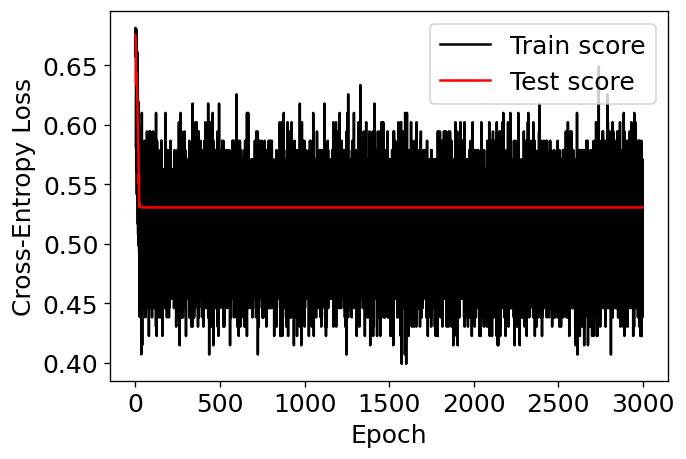

Optimal epoch count for the current training: 418
0.782608695652174 2930
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [02:03<00:00, 24.35it/s]


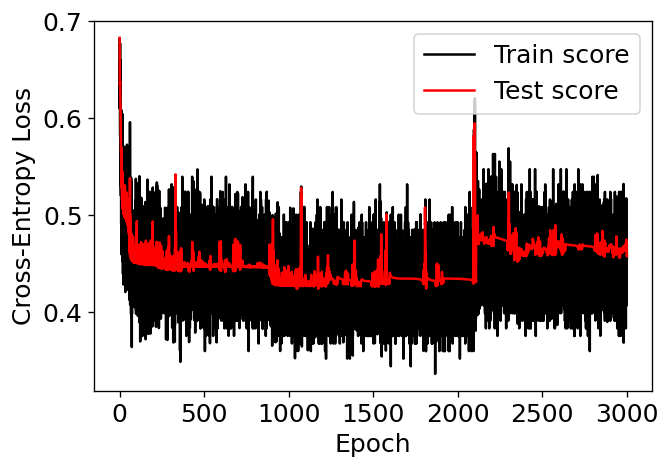

Optimal epoch count for the current training: 1048
0.893719806763285 7340
0.893719806763285 0.6920289855072463
---------------------------------------------


100%|██████████| 3000/3000 [02:02<00:00, 24.48it/s]


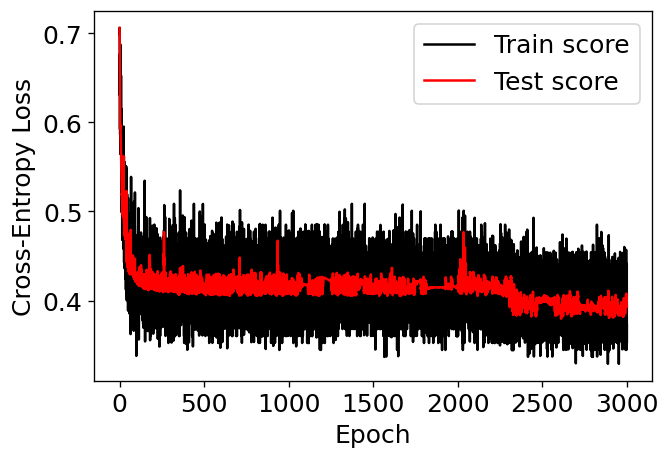

Optimal epoch count for the current training: 2610
0.9347826086956522 18276
0.9347826086956522 0.8253744393986405
---------------------------------------------


100%|██████████| 3000/3000 [02:03<00:00, 24.38it/s]


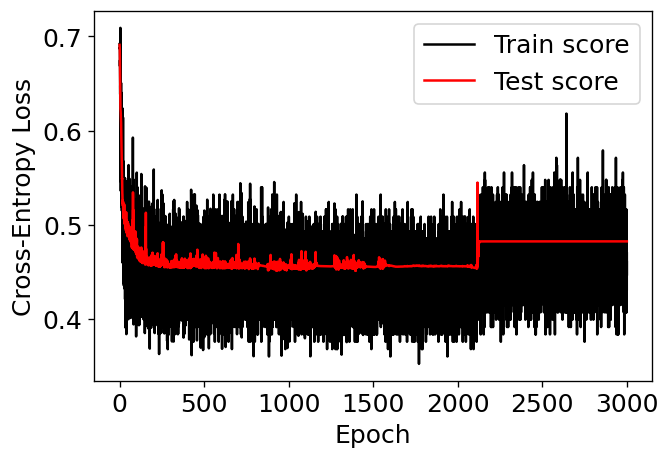

Optimal epoch count for the current training: 1395
0.8623188405797102 9771
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [02:01<00:00, 24.60it/s]


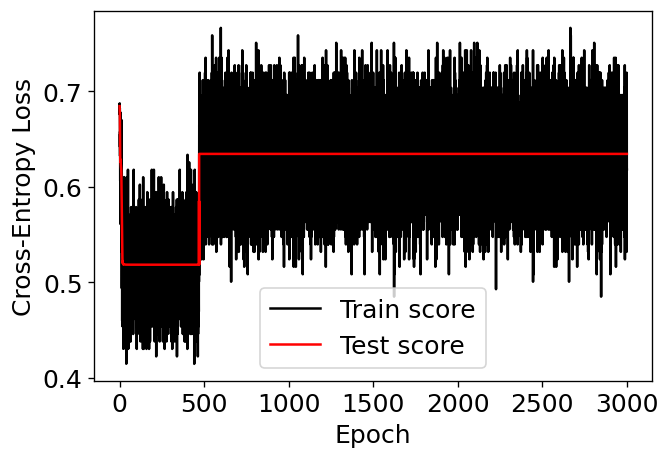

Optimal epoch count for the current training: 462
0.7946859903381642 3237
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [02:02<00:00, 24.41it/s]


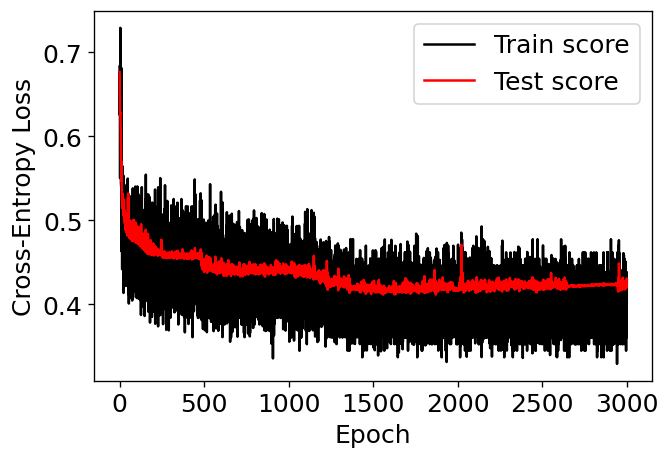

Optimal epoch count for the current training: 1559
0.9033816425120773 10913
0.9033816425120773 0.7388489016134643
---------------------------------------------


100%|██████████| 3000/3000 [02:02<00:00, 24.45it/s]


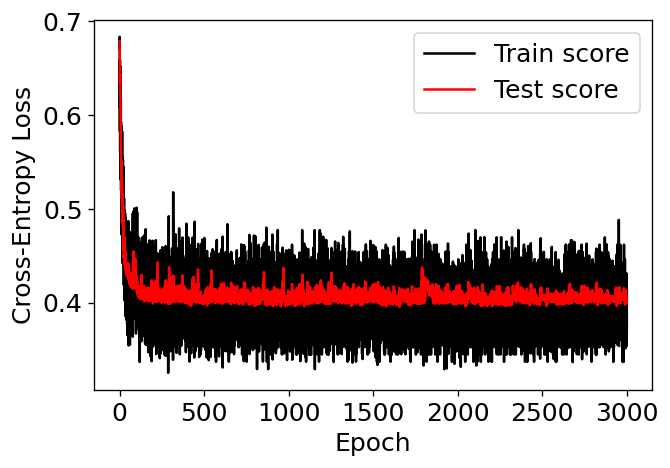

Optimal epoch count for the current training: 1656
0.9202898550724637 11597
0.9202898550724637 0.804629246064623
---------------------------------------------


100%|██████████| 3000/3000 [02:03<00:00, 24.39it/s]


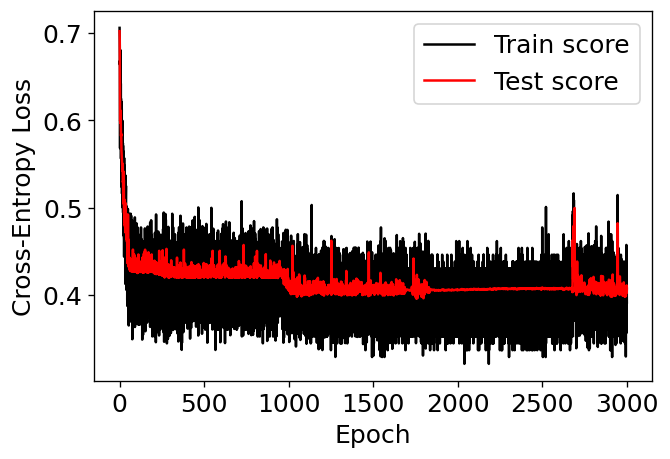

Optimal epoch count for the current training: 1756
0.9178743961352657 12294
0.9178743961352657 0.7626717062025781
---------------------------------------------


100%|██████████| 3000/3000 [02:02<00:00, 24.45it/s]


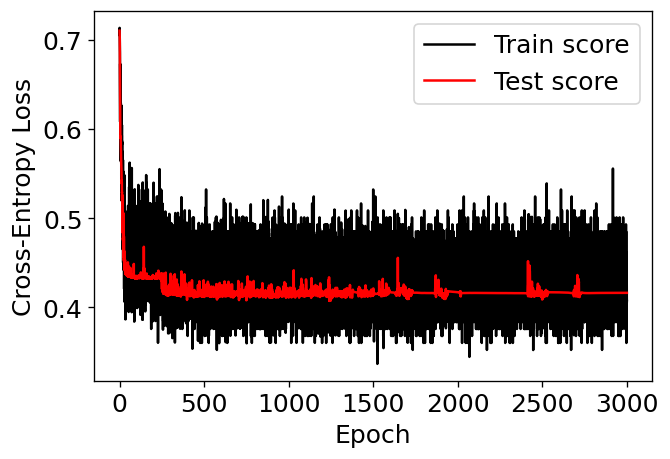

Optimal epoch count for the current training: 1240
0.9057971014492754 8682
0.9057971014492754 0.6847801191021531
---------------------------------------------


100%|██████████| 3000/3000 [02:03<00:00, 24.36it/s]


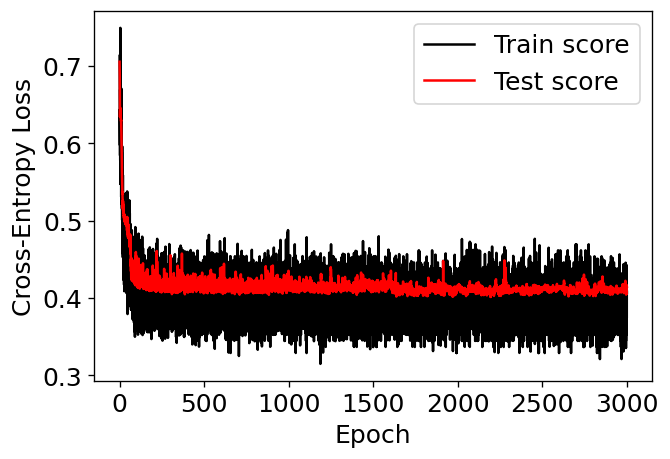

Optimal epoch count for the current training: 2195
0.9130434782608695 15365
0.9130434782608695 0.782608695652174
---------------------------------------------


100%|██████████| 3000/3000 [02:03<00:00, 24.37it/s]


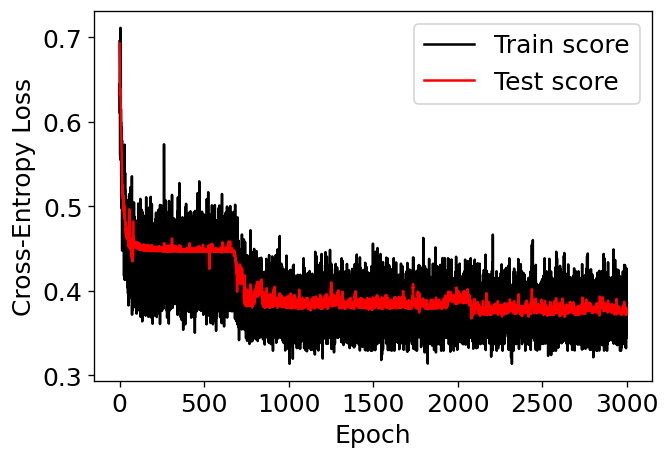

Optimal epoch count for the current training: 2081
0.9444444444444444 14571
0.9444444444444444 0.8416481360366252
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN2
TP = 104.5+/-11.715374513859981
TN = 274.8+/-9.086253353280437
FP = 7.1+/-3.5341194094144583
FN = 27.6+/-9.013323471395001
Acc = 0.9161835748792271+/-0.019445569625679927
TSS = 0.7653708222610527+/-0.06339160659699761


In [ ]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Best architecture for 60x60 VDFs (5-fold CV for faster assessment)

In [ ]:
class VDFCNN_6060_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*7*7, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 7 * 7)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*7*7, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 7 * 7)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*15*15, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 15 * 15)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*15*15, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 15 * 15)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*30*30, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 30 * 30)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*30*30, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 30 * 30)
    x = self.linearcell(x)
    return x

In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN1
ARCH = 'VDFCNN_6060_CNN3_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN2_CONN2
ARCH = 'VDFCNN_6060_CNN2_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN2_CONN1
ARCH = 'VDFCNN_6060_CNN2_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = 1990 + np.argmin(np.array(loss_history_test)[1990:])
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.86):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_6060_CNN3_CONN2

Running for the best configuration now...

100%|██████████| 3000/3000 [03:40<00:00, 13.58it/s]


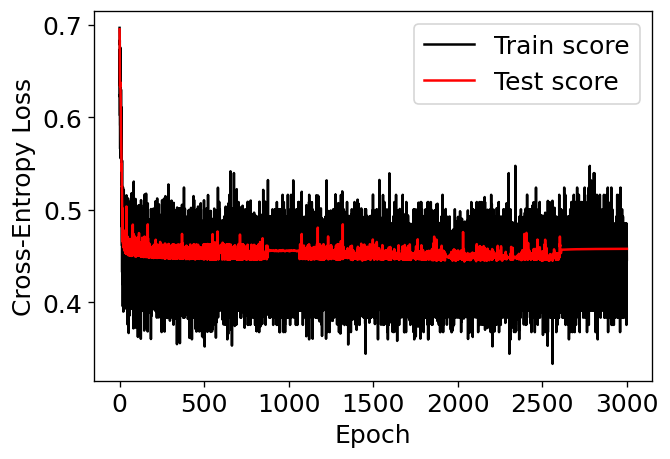

Optimal epoch count for the current training: 2038
0.8695652173913043 14269
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [03:41<00:00, 13.57it/s]


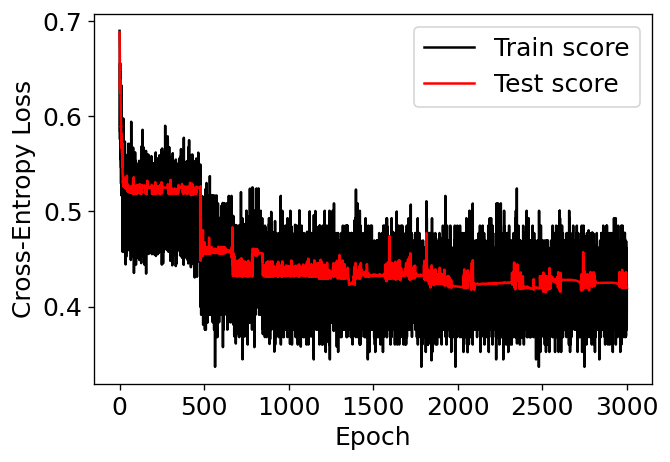

Optimal epoch count for the current training: 2518
0.8985507246376812 17632
0.8985507246376812 0.717391304347826
---------------------------------------------


100%|██████████| 3000/3000 [03:38<00:00, 13.72it/s]


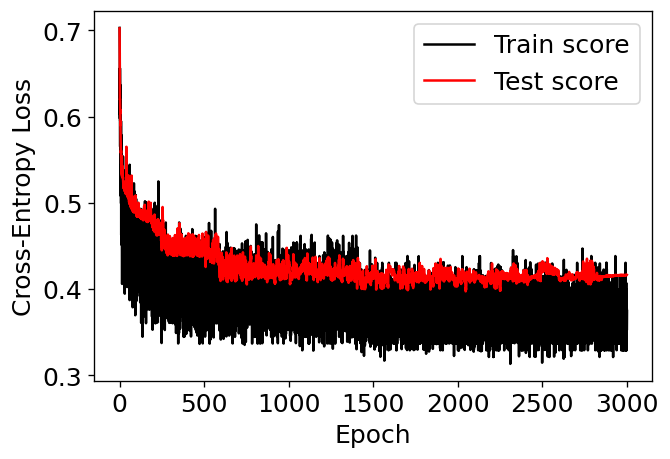

Optimal epoch count for the current training: 2046
0.9154589371980676 14325
0.9154589371980676 0.8160436678885826
---------------------------------------------


100%|██████████| 3000/3000 [03:36<00:00, 13.86it/s]


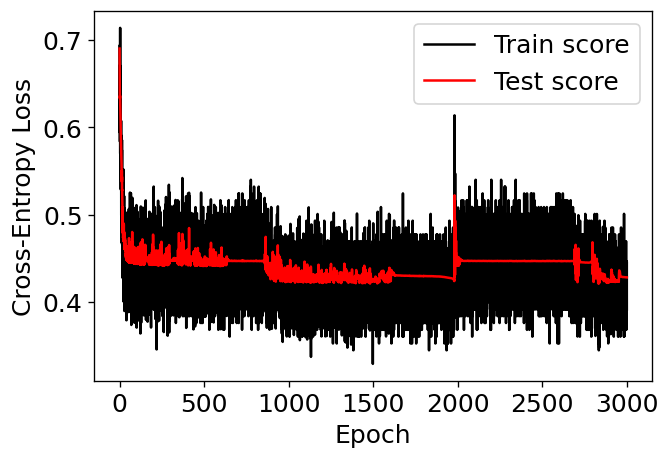

Optimal epoch count for the current training: 1481
0.893719806763285 10369
0.893719806763285 0.6920289855072463
---------------------------------------------


100%|██████████| 3000/3000 [03:42<00:00, 13.47it/s]


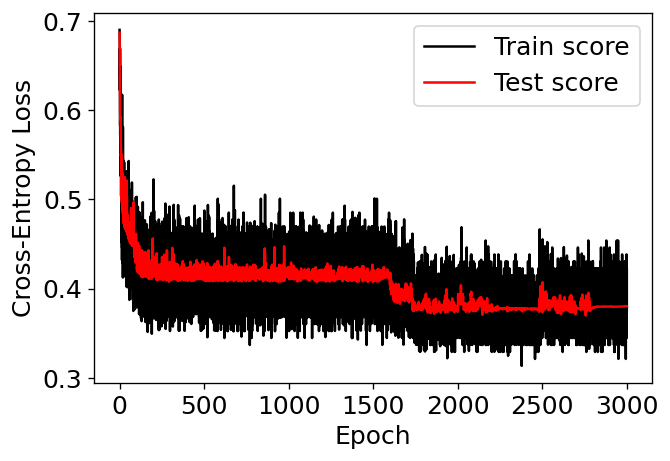

Optimal epoch count for the current training: 2756
0.9444444444444444 19298
0.9444444444444444 0.8632837841649508
---------------------------------------------


100%|██████████| 3000/3000 [03:43<00:00, 13.43it/s]


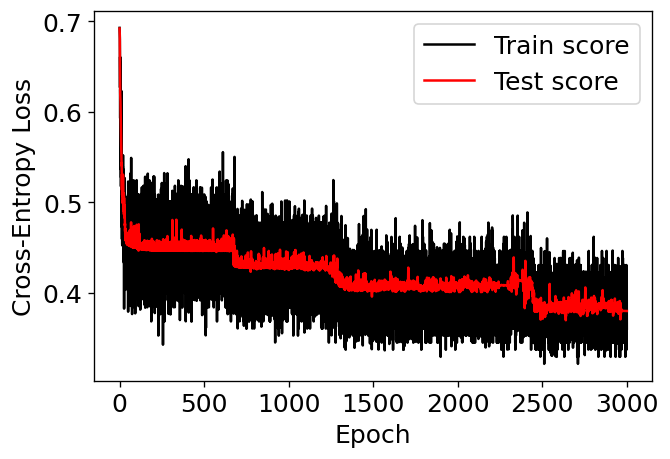

Optimal epoch count for the current training: 2638
0.9444444444444444 18472
0.9444444444444444 0.8349878254354748
---------------------------------------------


100%|██████████| 3000/3000 [03:41<00:00, 13.52it/s]


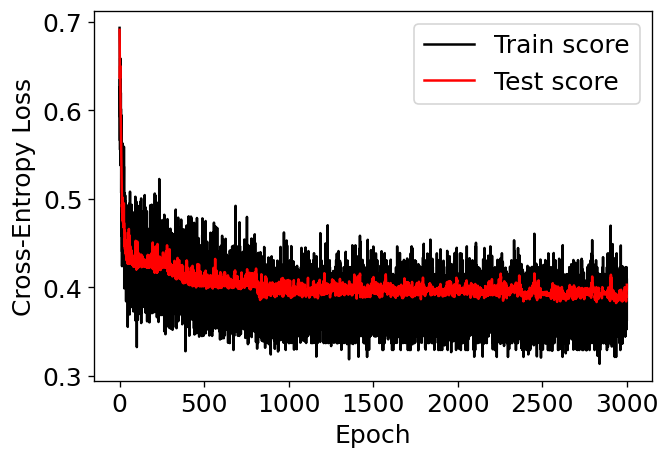

Optimal epoch count for the current training: 2936
0.9323671497584541 20554
0.9323671497584541 0.8331089478044739
---------------------------------------------


100%|██████████| 3000/3000 [03:39<00:00, 13.66it/s]


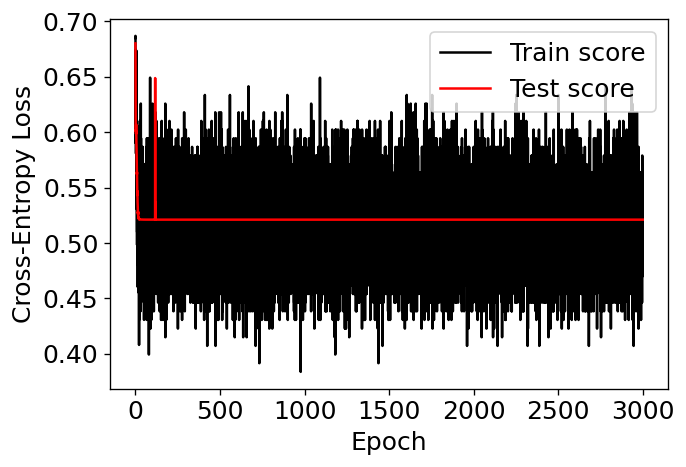

Optimal epoch count for the current training: 182
0.7922705314009661 1280
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [03:36<00:00, 13.88it/s]


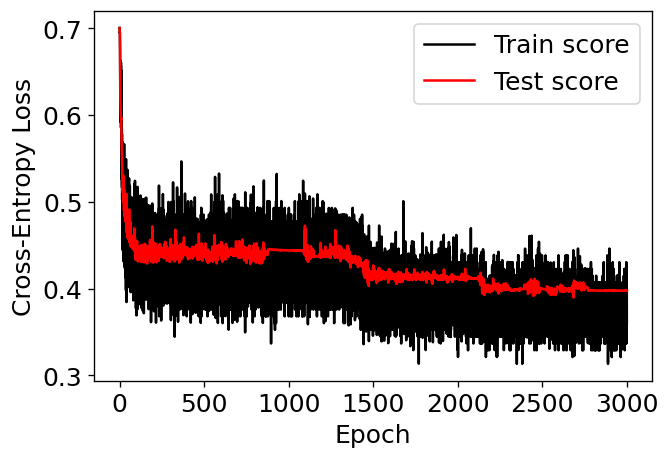

Optimal epoch count for the current training: 2685
0.9251207729468599 18795
0.9251207729468599 0.8068710687388938
---------------------------------------------


100%|██████████| 3000/3000 [03:42<00:00, 13.49it/s]


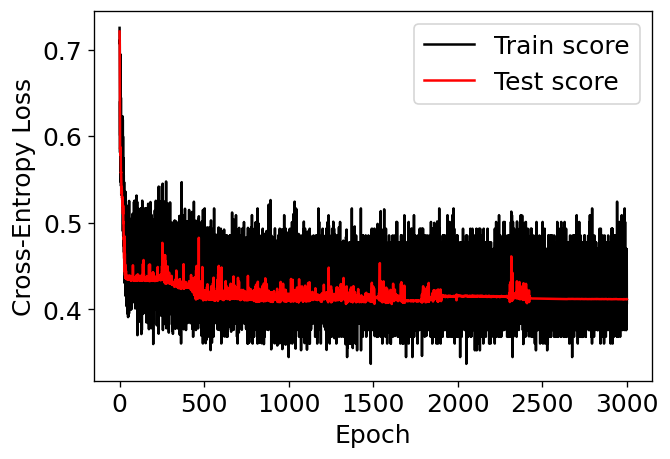

Optimal epoch count for the current training: 1609
0.9082125603864735 11264
0.9082125603864735 0.7595052679798443
---------------------------------------------


100%|██████████| 3000/3000 [03:41<00:00, 13.57it/s]


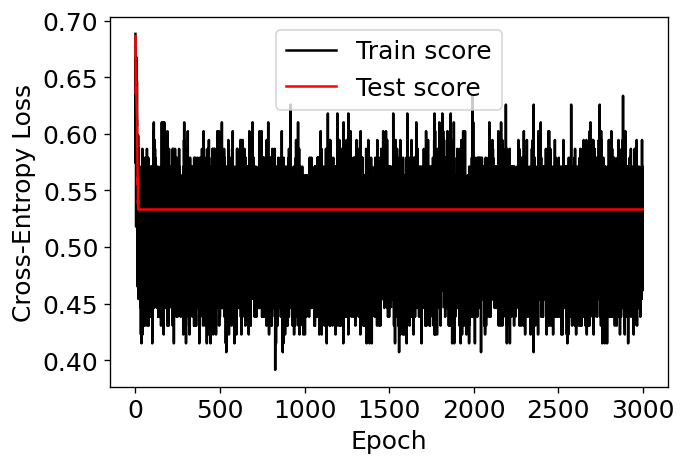

Optimal epoch count for the current training: 183
0.7801932367149759 1283
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [03:34<00:00, 13.97it/s]


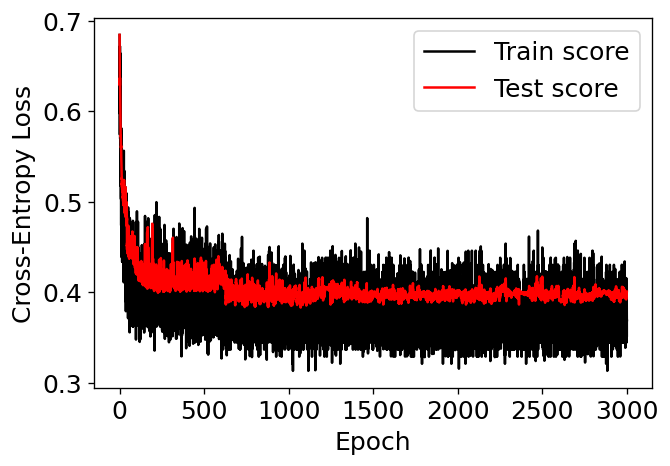

Optimal epoch count for the current training: 1070
0.9323671497584541 7496
0.9323671497584541 0.8405797101449276
---------------------------------------------


100%|██████████| 3000/3000 [03:39<00:00, 13.68it/s]


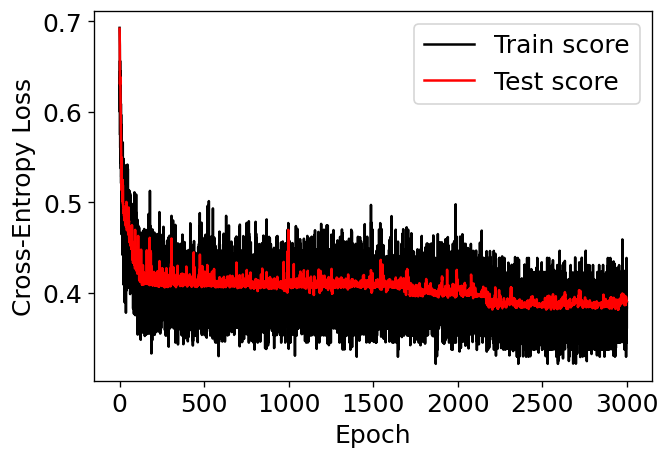

Optimal epoch count for the current training: 2947
0.9323671497584541 20634
0.9323671497584541 0.8412557226945716
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
TP = 110.5+/-10.131633629380802
TN = 271.5+/-7.915175298121956
FP = 10.4+/-5.314132102234569
FN = 21.6+/-8.957678270623477
Acc = 0.9227053140096618+/-0.01707987394170405
TSS = 0.8005056284706791+/-0.054861415744509104


In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Tests for individual runs

Implementation of early stopping is necessary here. The runs behave very active

In [25]:
simfiles = ['particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
    'particles.d11_A0.75Hepp_beta1_256',\
    'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
    'particles.d11_E11Ap4.3Aa1.6',\
    'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
    'particles.d11_He++A10_256_iden0eps0',\
    'particles.d11_He++v2_256_iden0eps1e-4t600',\
    'particles.d11_He++vd1.5_256_iden0eps1e-4',\
    'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
    'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
    'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
    'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
    'particles.d11_vap1.5Ap1.5Aa1rdna_0.007']

In [26]:
def outputclass_analysis_scorereturn_spec(test_labels, predicted_labels):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(test_labels)):
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 0) ): tn += 1
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 1) ): fp += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 0) ): fn += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 1) ): tp += 1
    acc = (tp+tn)/(tp+fn+fp+tn)
    if ( ((tp + fn) == 0) or ((fp + tn) == 0) ):
      tss = -1
    else:
      tss = tp/(tp+fn) - fp/(fp+tn)
    return tp, tn, fp, fn, acc, tss

100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


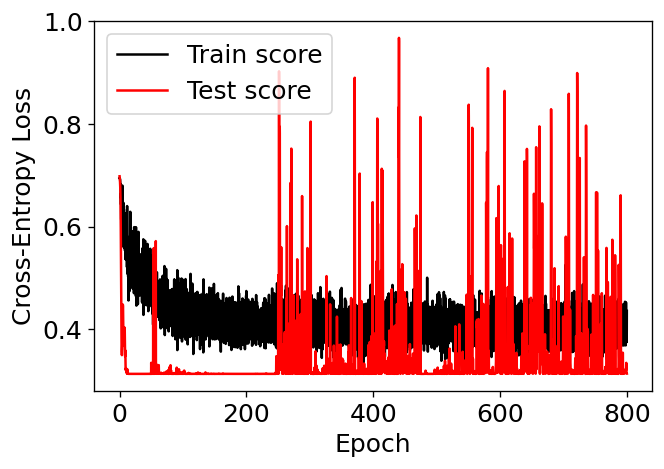

Optimal epoch count for the current training: 144
1.0 1299
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.95it/s]


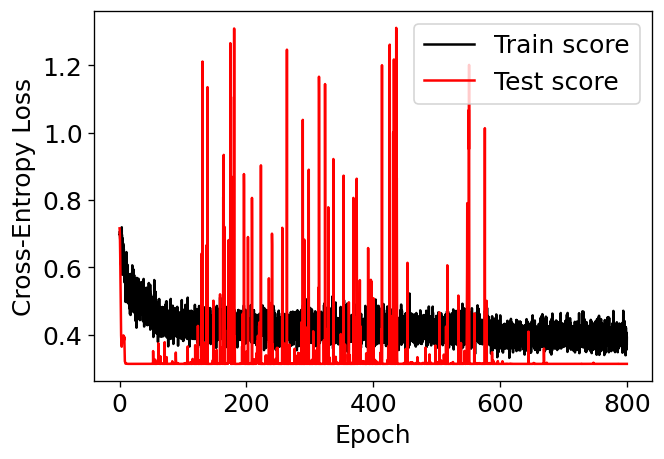

Optimal epoch count for the current training: 39
1.0 356
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.84it/s]


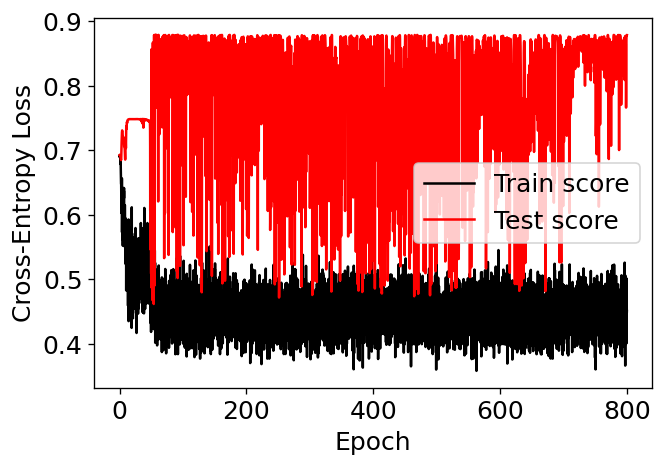

Optimal epoch count for the current training: 53
0.9130434782608695 485
0.9130434782608695 0.8
---------------------------------------------


100%|██████████| 800/800 [00:49<00:00, 16.01it/s]


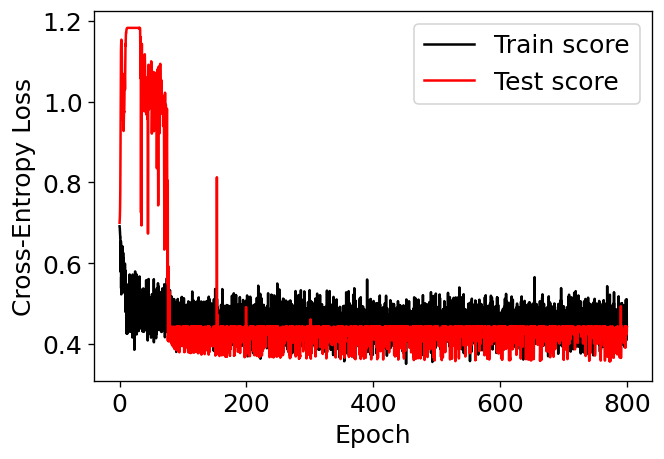

Optimal epoch count for the current training: 773
0.9565217391304348 6958
0.9565217391304348 0.8083333333333333
---------------------------------------------


100%|██████████| 800/800 [00:49<00:00, 16.06it/s]


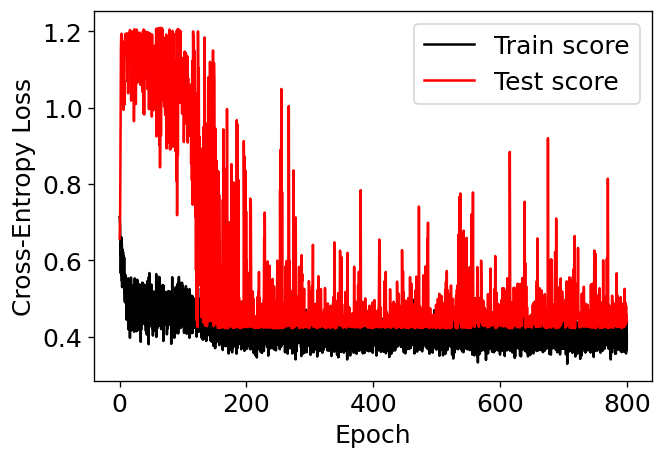

Optimal epoch count for the current training: 532
0.8913043478260869 4793
0.8913043478260869 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


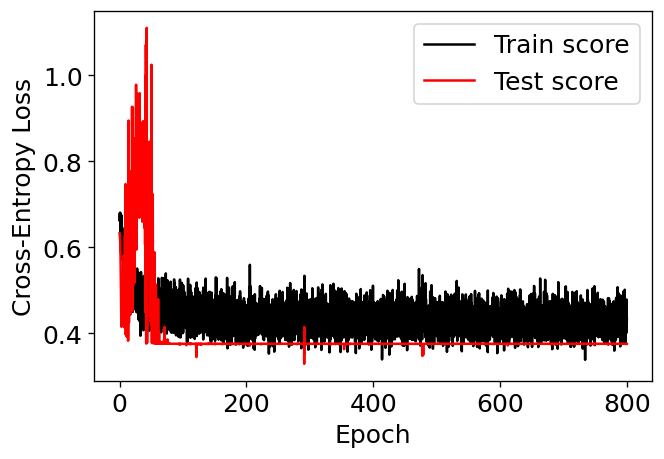

Optimal epoch count for the current training: 291
1.0 2620
1.0 1.0
---------------------------------------------


100%|██████████| 800/800 [00:52<00:00, 15.16it/s]


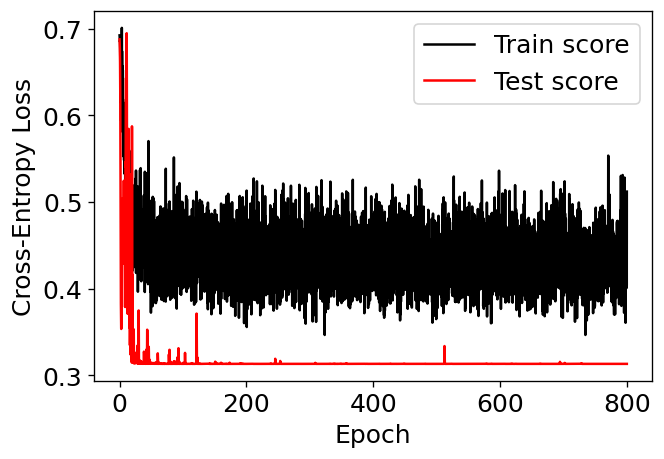

Optimal epoch count for the current training: 85
1.0 770
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.51it/s]


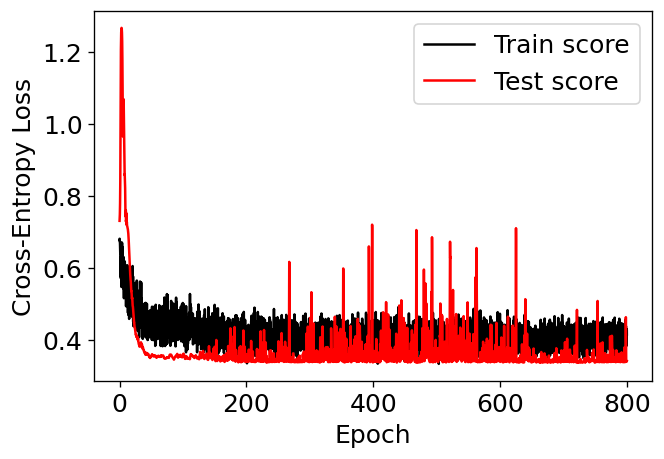

Optimal epoch count for the current training: 662
0.9782608695652174 5965
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.93it/s]


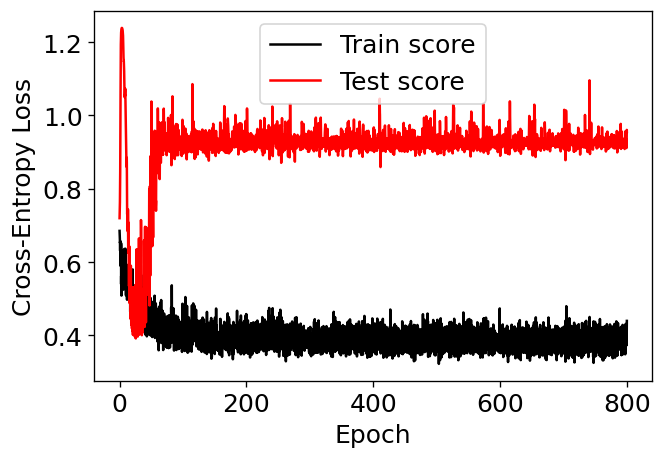

Optimal epoch count for the current training: 25
0.9333333333333333 230
0.9333333333333333 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.99it/s]


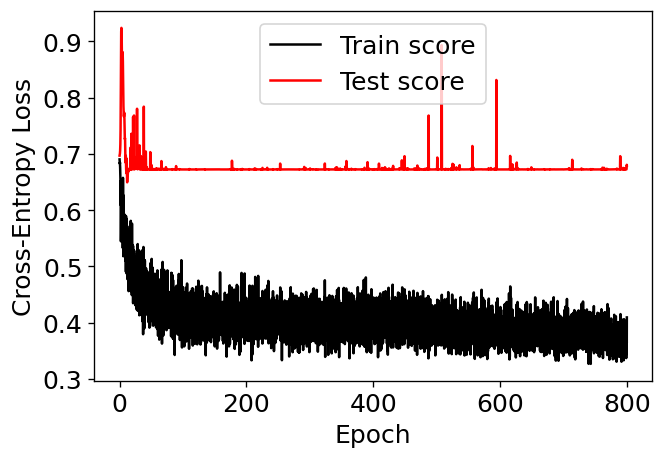

Optimal epoch count for the current training: 12
0.6410256410256411 108
0.6410256410256411 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


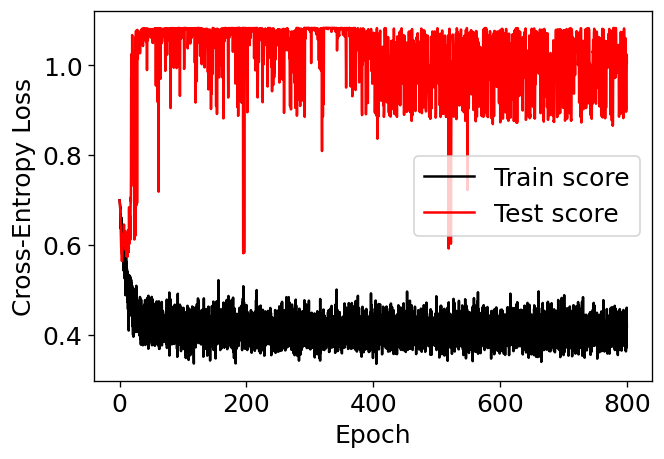

Optimal epoch count for the current training: 3
0.7702702702702703 33
0.7702702702702703 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.53it/s]


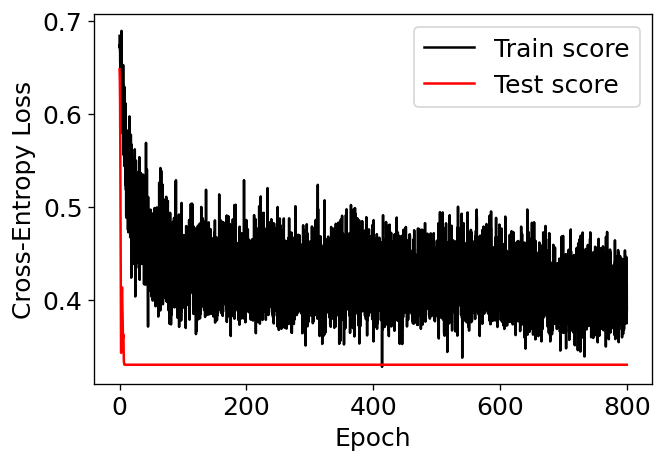

Optimal epoch count for the current training: 10
0.9827586206896551 90
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.68it/s]


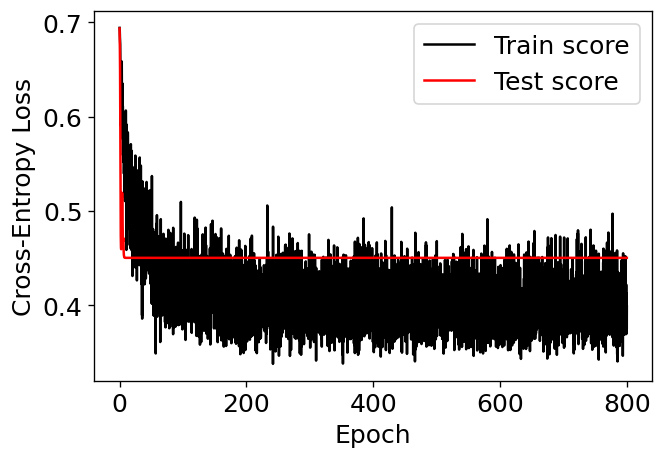

Optimal epoch count for the current training: 12
0.863013698630137 111
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.64it/s]


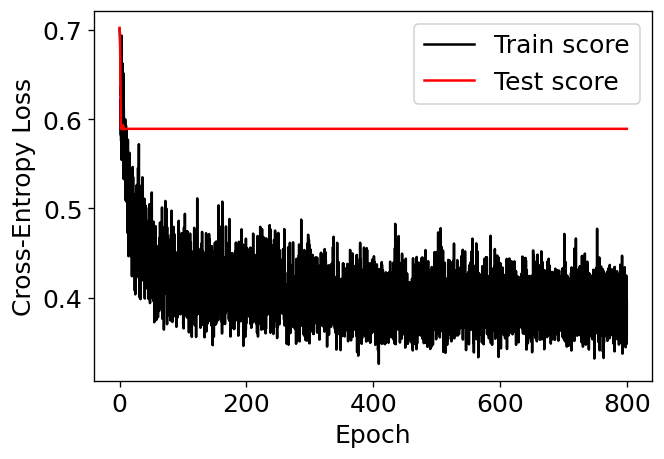

Optimal epoch count for the current training: 7
0.7241379310344828 68
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.60it/s]


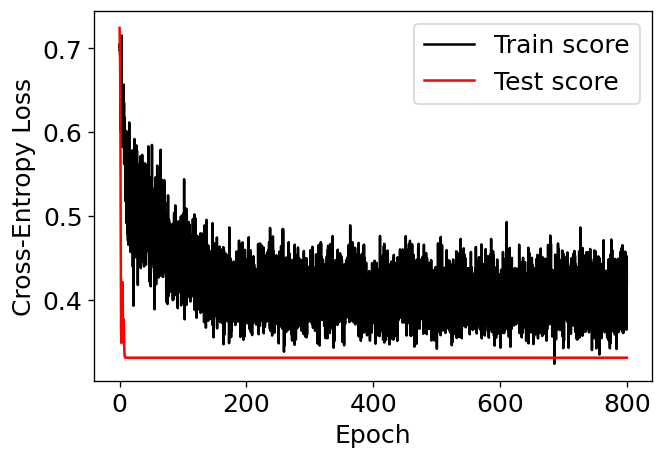

Optimal epoch count for the current training: 10
0.9827586206896551 92
0.9827586206896551 0.0
---------------------------------------------


 61%|██████    | 486/800 [00:31<00:20, 15.31it/s]


KeyboardInterrupt: 

In [27]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([22], dtype=int)
tn = np.zeros([22], dtype=int)
fp = np.zeros([22], dtype=int)
fn = np.zeros([22], dtype=int)
acc = np.zeros([22], dtype=float)
tss = np.zeros([22], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 800
    n_iterations = 9 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)

100%|██████████| 800/800 [01:02<00:00, 12.80it/s]


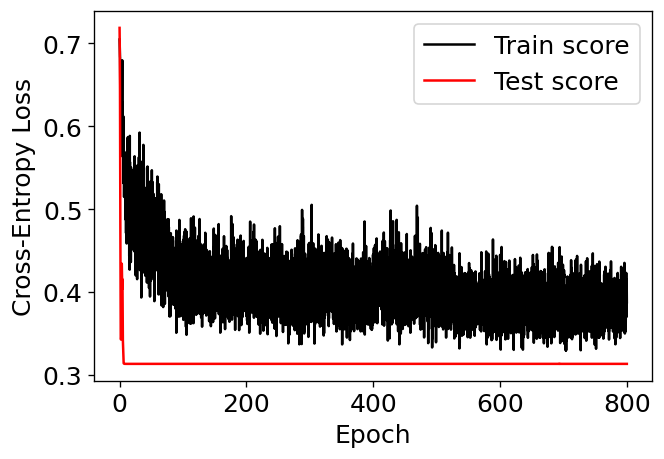

Optimal epoch count for the current training: 10
1.0 97
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.35it/s]


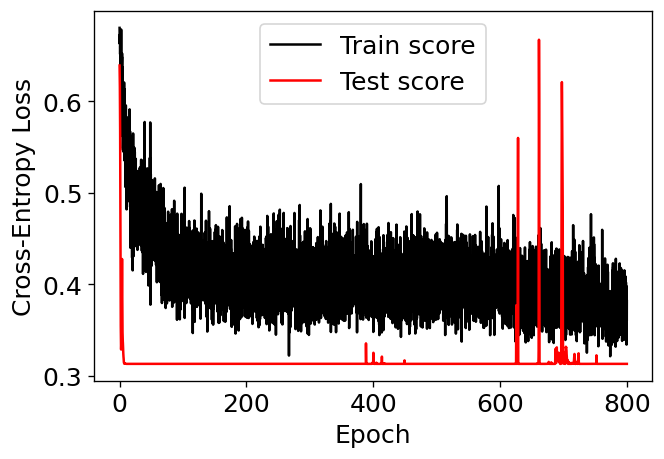

Optimal epoch count for the current training: 11
1.0 103
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.35it/s]


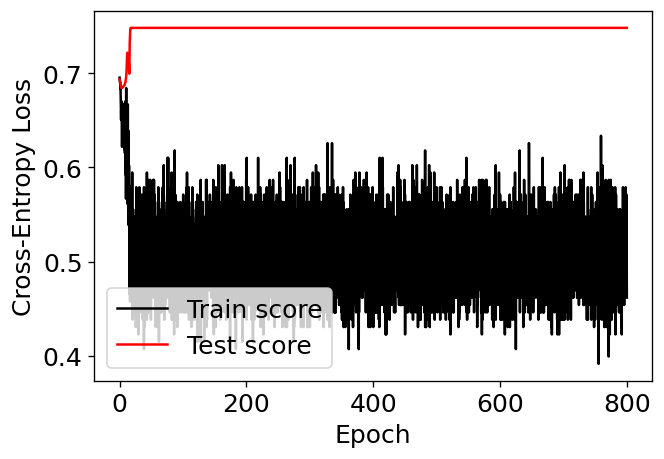

Optimal epoch count for the current training: 2
0.5652173913043478 21
0.5652173913043478 0.0
---------------------------------------------


100%|██████████| 800/800 [01:01<00:00, 13.04it/s]


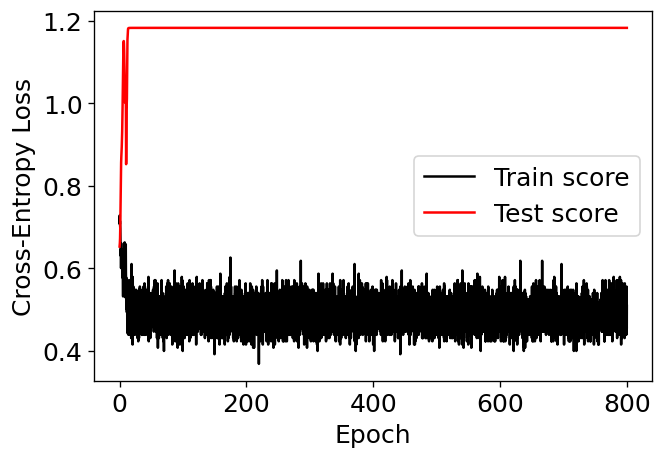

Optimal epoch count for the current training: 0
0.8695652173913043 0
0.8695652173913043 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.58it/s]


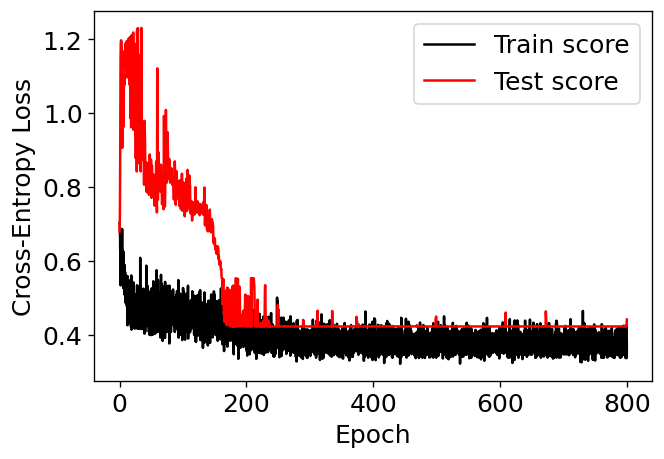

Optimal epoch count for the current training: 692
0.8913043478260869 6234
0.8913043478260869 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.40it/s]


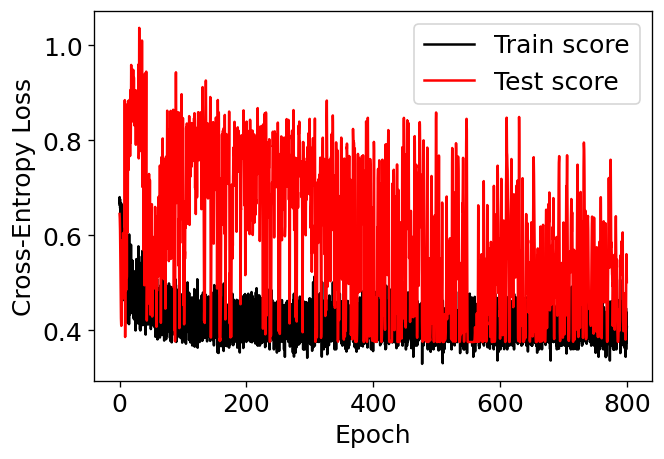

Optimal epoch count for the current training: 555
0.9375 5002
0.9375 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.53it/s]


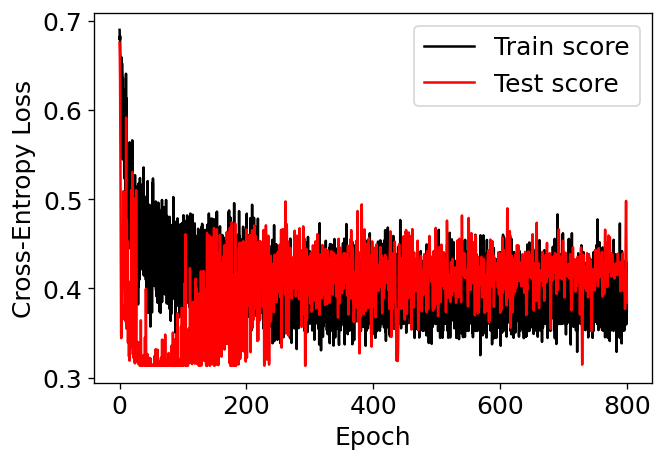

Optimal epoch count for the current training: 86
1.0 777
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.44it/s]


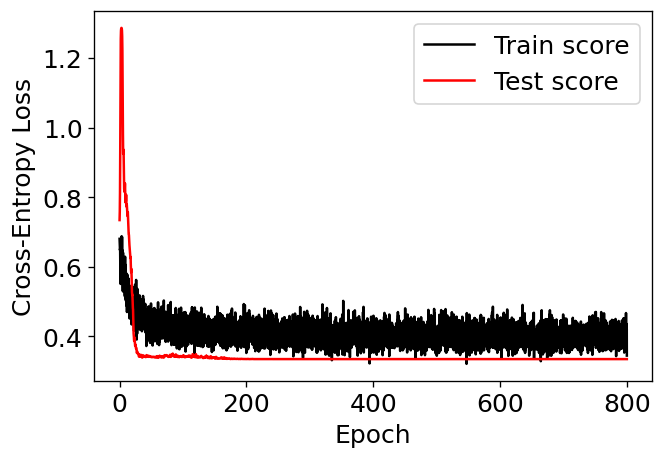

Optimal epoch count for the current training: 300
0.9782608695652174 2705
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.55it/s]


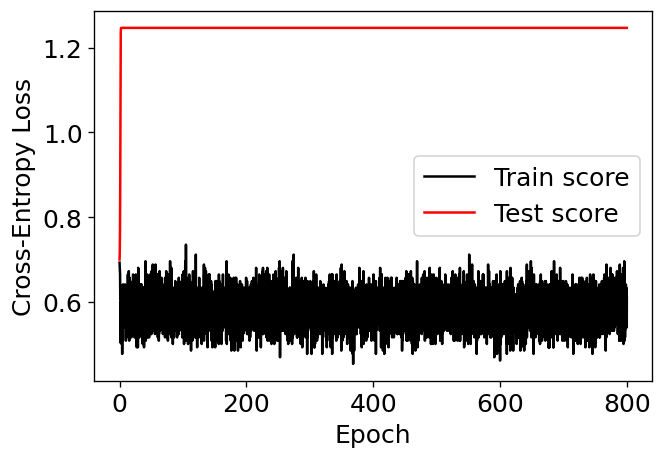

Optimal epoch count for the current training: 0
0.06666666666666667 0
0.06666666666666667 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.54it/s]


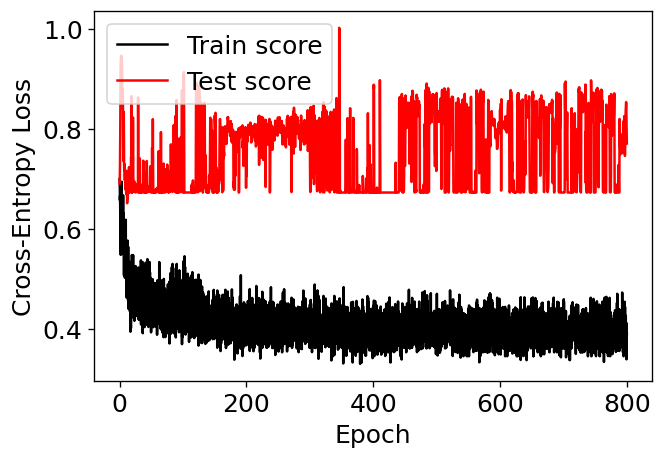

Optimal epoch count for the current training: 11
0.6410256410256411 107
0.6410256410256411 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.54it/s]


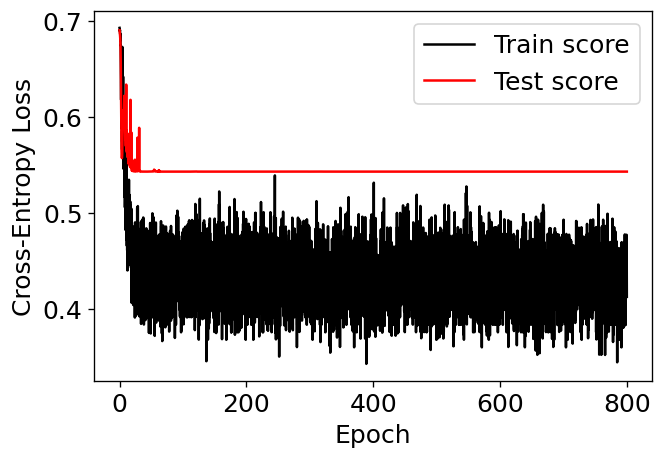

Optimal epoch count for the current training: 511
0.7702702702702703 4600
0.7702702702702703 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.68it/s]


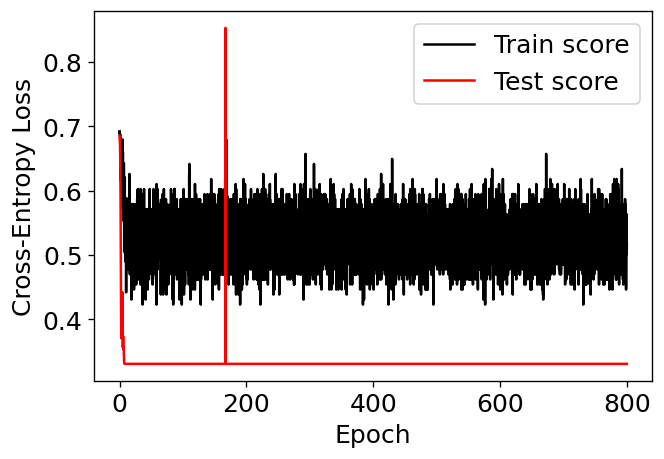

Optimal epoch count for the current training: 9
0.9827586206896551 82
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.61it/s]


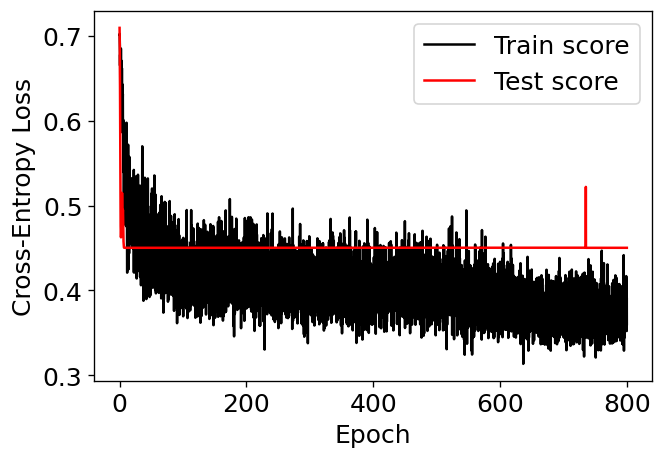

Optimal epoch count for the current training: 9
0.863013698630137 88
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.62it/s]


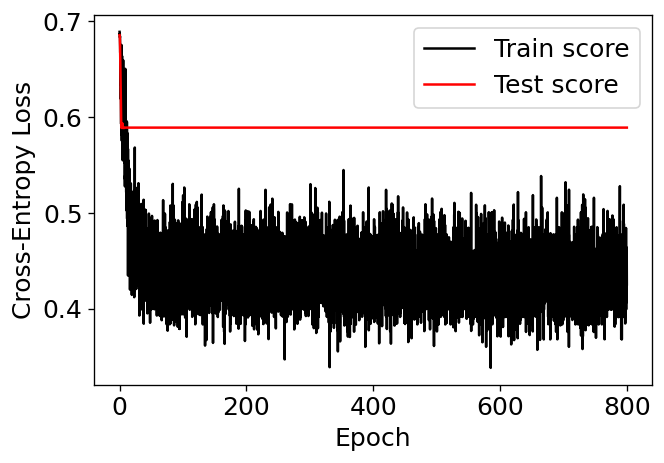

Optimal epoch count for the current training: 5
0.7241379310344828 49
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.47it/s]


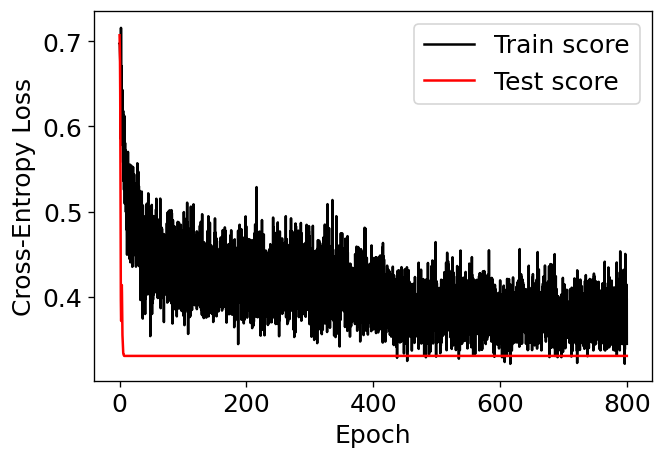

Optimal epoch count for the current training: 8
0.9827586206896551 76
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.37it/s]


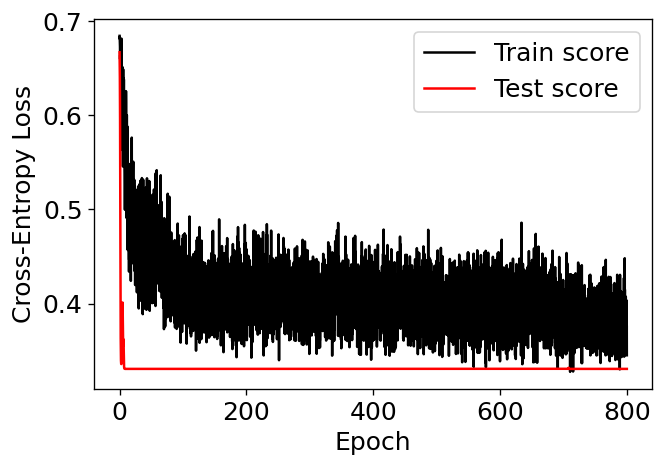

Optimal epoch count for the current training: 9
0.9827586206896551 82
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.69it/s]


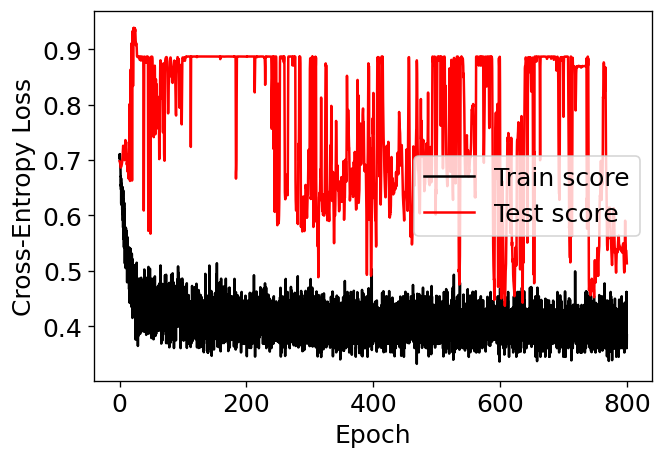

Optimal epoch count for the current training: 607
0.9180327868852459 5468
0.9180327868852459 0.8224400871459695
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.48it/s]


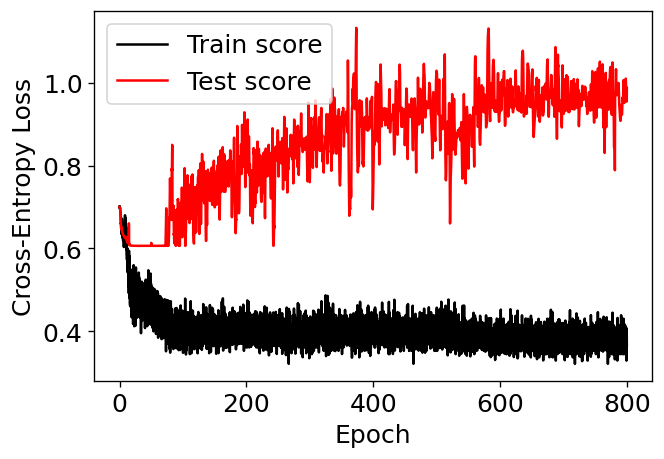

Optimal epoch count for the current training: 75
0.7068965517241379 678
0.7068965517241379 0.0
---------------------------------------------


100%|██████████| 800/800 [01:02<00:00, 12.81it/s]


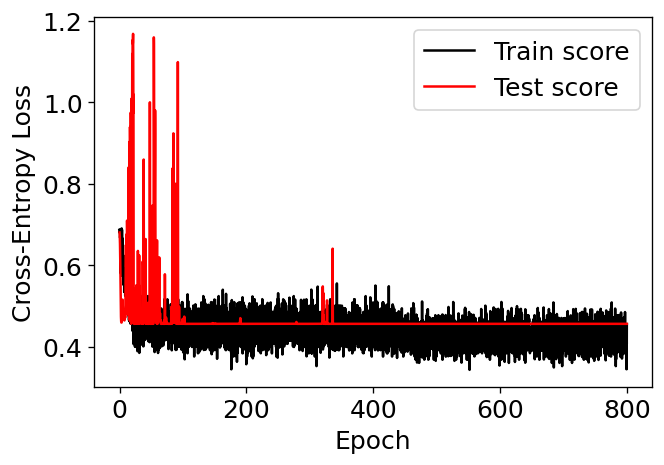

Optimal epoch count for the current training: 106
0.8571428571428571 962
0.8571428571428571 0.0
---------------------------------------------


100%|██████████| 800/800 [01:01<00:00, 13.04it/s]


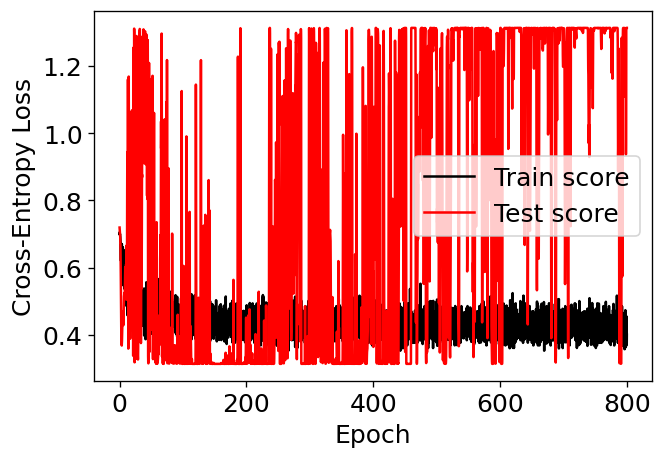

Optimal epoch count for the current training: 115
1.0 1041
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.46it/s]


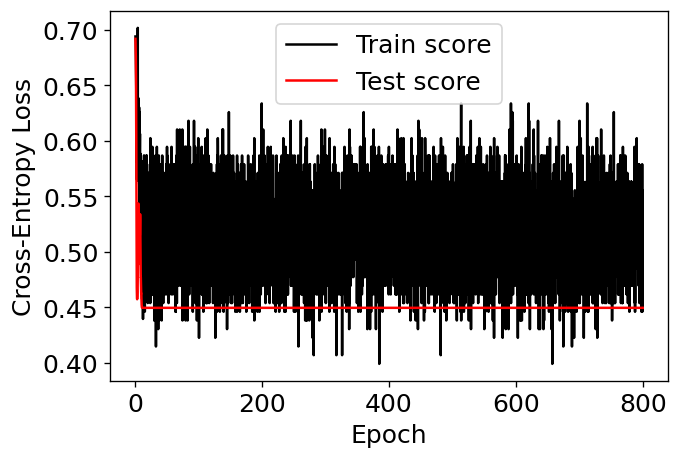

Optimal epoch count for the current training: 12
0.8636363636363636 109
0.8636363636363636 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.39it/s]


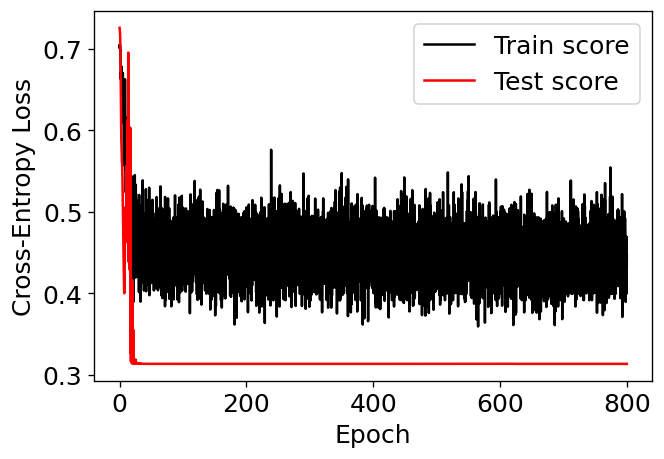

Optimal epoch count for the current training: 87
1.0 786
1.0 -1.0
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
TP = 9.045454545454545+/-17.234946719666763
TN = 37.0+/-27.809416325475734
FP = 1.8636363636363635+/-5.918349390170561
FN = 9.045454545454545+/-18.48704035688311
Acc = 0.8454975661441693+/-0.21075821153275362
TSS = -0.1898890869479105+/-0.47112701720172245
[1.         1.         0.56521739 0.86956522 0.89130435 0.9375
 1.         0.97826087 0.06666667 0.64102564 0.77027027 0.98275862
 0.8630137  0.72413793 0.98275862 0.98275862 0.91803279 0.70689655
 0.85714286 1.         0.86363636 1.        ]
[-1.         -1.          0.          0.          0.          0.
 -1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.82244009  0.
  0.         -1.          0.         -1.        ]


In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([22], dtype=int)
tn = np.zeros([22], dtype=int)
fp = np.zeros([22], dtype=int)
fn = np.zeros([22], dtype=int)
acc = np.zeros([22], dtype=float)
tss = np.zeros([22], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 800
    n_iterations = 9 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)

# Weight decay to prevent overfitting

In [12]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*5*5, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 5 * 5)
    x = self.linearcell(x)
    return x

In [16]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 3000/3000 [03:06<00:00, 16.05it/s]


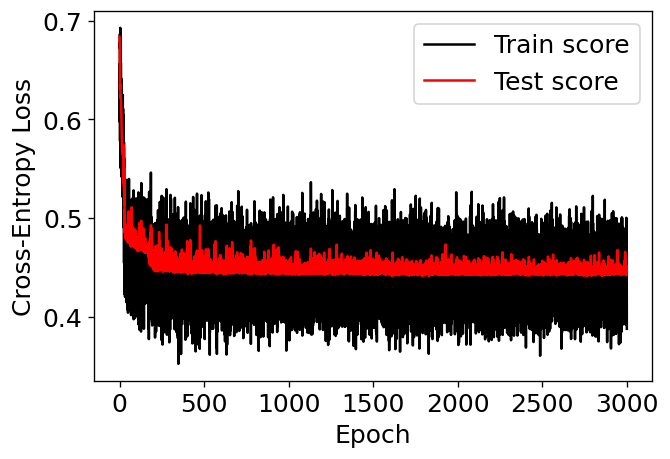

Optimal epoch count for the current training: 1611
0.8816425120772947 12890
0.8816425120772947 0.6630434782608696
---------------------------------------------


100%|██████████| 3000/3000 [03:21<00:00, 14.92it/s]


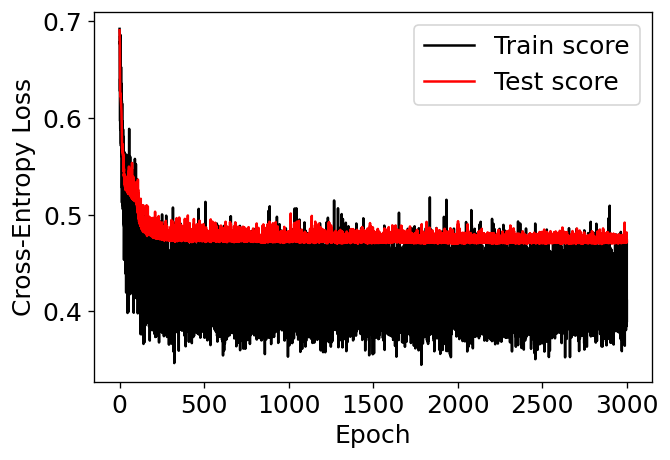

Optimal epoch count for the current training: 2851
0.857487922705314 22813
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [03:05<00:00, 16.14it/s]


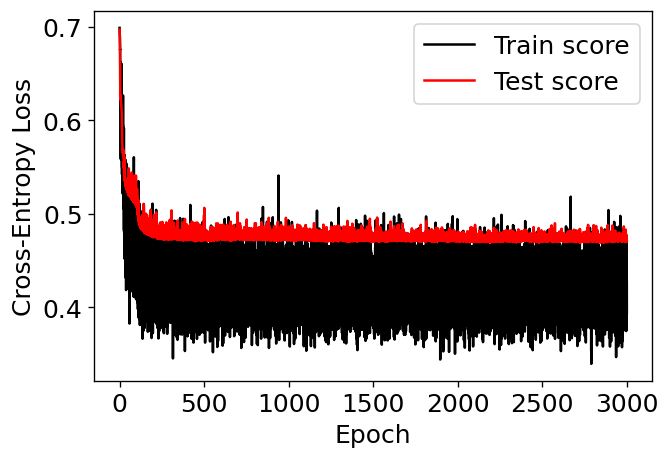

Optimal epoch count for the current training: 2863
0.855072463768116 22906
RERUNNING THE SAMPLE...


  4%|▍         | 131/3000 [00:08<03:07, 15.26it/s]


KeyboardInterrupt: 

In [17]:
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 8 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

100%|██████████| 20/20 [00:01<00:00, 12.51it/s]


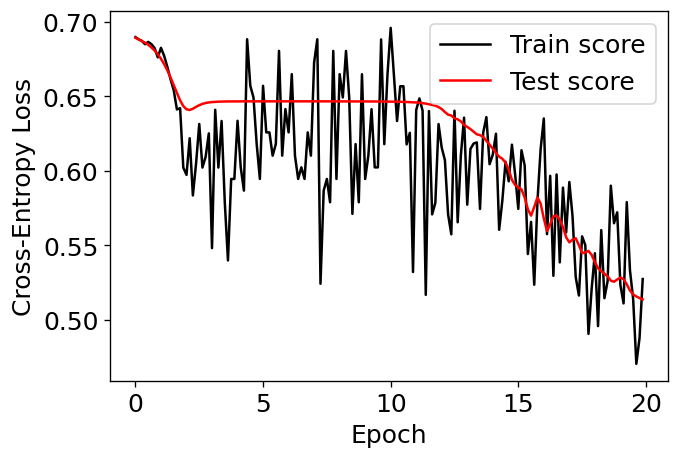

Optimal epoch count for the current training: 19
[0.6892232894897461, 0.688072919845581, 0.6870402693748474, 0.6858956813812256, 0.6844990849494934, 0.6827240586280823, 0.6806728839874268, 0.6781937479972839, 0.6751644611358643, 0.671521782875061, 0.6673073172569275, 0.6625561714172363, 0.6573930978775024, 0.6520962119102478, 0.6471993923187256, 0.6434027552604675, 0.6412366032600403, 0.64078688621521, 0.6415966749191284, 0.6428826451301575, 0.6440078616142273, 0.6448685526847839, 0.6454539895057678, 0.6458353400230408, 0.6460940837860107, 0.6462576389312744, 0.6463637948036194, 0.6464331150054932, 0.6464794278144836, 0.6465110778808594, 0.6465328931808472, 0.6465482115745544, 0.6465588808059692, 0.6465663313865662, 0.6465717554092407, 0.6465756297111511, 0.6465786695480347, 0.6465808153152466, 0.6465823650360107, 0.6465834975242615, 0.6465843319892883, 0.6465850472450256, 0.6465855836868286, 0.6465858221054077, 0.6465858817100525, 0.6465861201286316, 0.6465861201286316, 0.646585822105

100%|██████████| 20/20 [00:01<00:00, 13.52it/s]


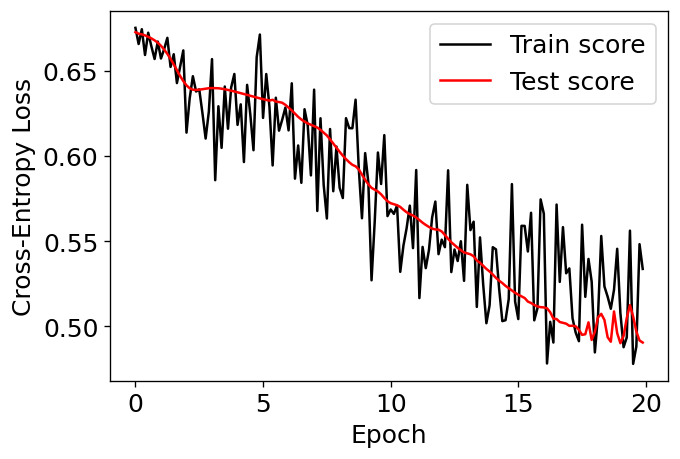

Optimal epoch count for the current training: 19
[0.6726625561714172, 0.6717956066131592, 0.6713944673538208, 0.6707658767700195, 0.6699758172035217, 0.6690084934234619, 0.6679021716117859, 0.6664831638336182, 0.6646808385848999, 0.6625092029571533, 0.6599297523498535, 0.6570004224777222, 0.6537926197052002, 0.650384783744812, 0.6469905972480774, 0.6439729332923889, 0.6414744853973389, 0.6397608518600464, 0.6389284729957581, 0.6387535333633423, 0.6389336585998535, 0.639234185218811, 0.6395473480224609, 0.6397894024848938, 0.6398884057998657, 0.6398085951805115, 0.6397687196731567, 0.639521062374115, 0.6391938328742981, 0.6388010382652283, 0.6383599638938904, 0.6378923654556274, 0.6374016404151917, 0.6368834972381592, 0.6363832950592041, 0.6358601450920105, 0.635334312915802, 0.6348486542701721, 0.634340226650238, 0.6338338851928711, 0.6333698630332947, 0.632934033870697, 0.6325437426567078, 0.6330015063285828, 0.6319455504417419, 0.6316812634468079, 0.6312638521194458, 0.63004505634307

100%|██████████| 20/20 [00:01<00:00, 13.39it/s]


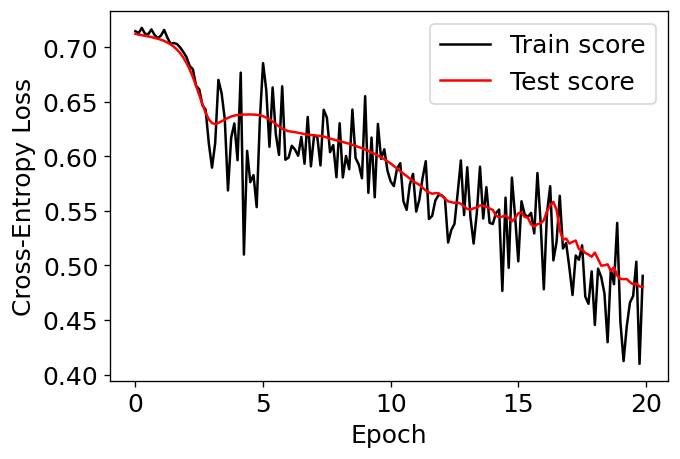

Optimal epoch count for the current training: 19
[0.7123036980628967, 0.7115694284439087, 0.7110217809677124, 0.7105302214622498, 0.7099422812461853, 0.709307074546814, 0.7085474133491516, 0.7077244520187378, 0.706874668598175, 0.7057697772979736, 0.7043258547782898, 0.7026666402816772, 0.7004773616790771, 0.6978452205657959, 0.694628119468689, 0.6905704140663147, 0.6855860352516174, 0.6796364784240723, 0.6726300716400146, 0.664739191532135, 0.6561862230300903, 0.6476965546607971, 0.6399151086807251, 0.6339853405952454, 0.6304035782814026, 0.6296365261077881, 0.6306450963020325, 0.6321505308151245, 0.6336420178413391, 0.6352144479751587, 0.6364848017692566, 0.6373112797737122, 0.6379040479660034, 0.6380303502082825, 0.6382960677146912, 0.6383718848228455, 0.6383706331253052, 0.6382580399513245, 0.6381369233131409, 0.6376806497573853, 0.6367653608322144, 0.6354445219039917, 0.6338599920272827, 0.6318206191062927, 0.6295536160469055, 0.6274293065071106, 0.6253389120101929, 0.623961806297

100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


KeyboardInterrupt: 

In [24]:
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 20
    n_iterations = 8 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    print(loss_history_test)
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))